In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 2
2023-07-31 15:19:49.769630


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-12.9182)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(8.5986)
penalty_target_min tensor(-11.6229) penalty_target_max tensor(5.3304)
train_loss:  -8.42597192583084
valid_loss:  -8.129956848144532
h_min_tilde -11.622948 ell_tilde -8.366768910293578 kappa_tilde 0.0005541736588958331


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.1920928955078125e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 4.009811878204346

 2 3.9038150310516357

 3 7.070861577987671

 4 5.554560422897339

 5 3.3611061573028564

 6 3.3544163703918457

 7 5.5229411125183105

 8 3.5880472660064697

 9 3.5066490173339844

 10 3.47279953956604

 11 5.368836164474487

 12 7.034075021743774

 13 7.4281535148620605

 14 5.836491584777832

 15 3.6801345348358154

 16 4.130544185638428

 17 5.418826341629028

 18 3.9229235649108887

 19 3.724292039871216

 20 3.3211216926574707

 21 4.1632349491119385

 22 3.3881633281707764

 23 3.6180543899536133

 24 3.544403076171875

 25 3.463517904281616

 26 4.307554721832275

 27 3.4695684909820557

 28 3.51405930519104

 29 5.83135461807251

 30 6.986378192901611

 31 4.706183195114136

 32 7.053839445114136

 33 4.528443336486816

 34 4.894865274429321

 35 4.879305839538574

 36 6.93683648109436

 37 6.722839117050171

 38 5.881831407546997

 39 5.672956228256226

 40 3.994417428970337

 41 5.855199337005615

 42 3.5499987602233887

 43 3.516850471496582

 44 3.55

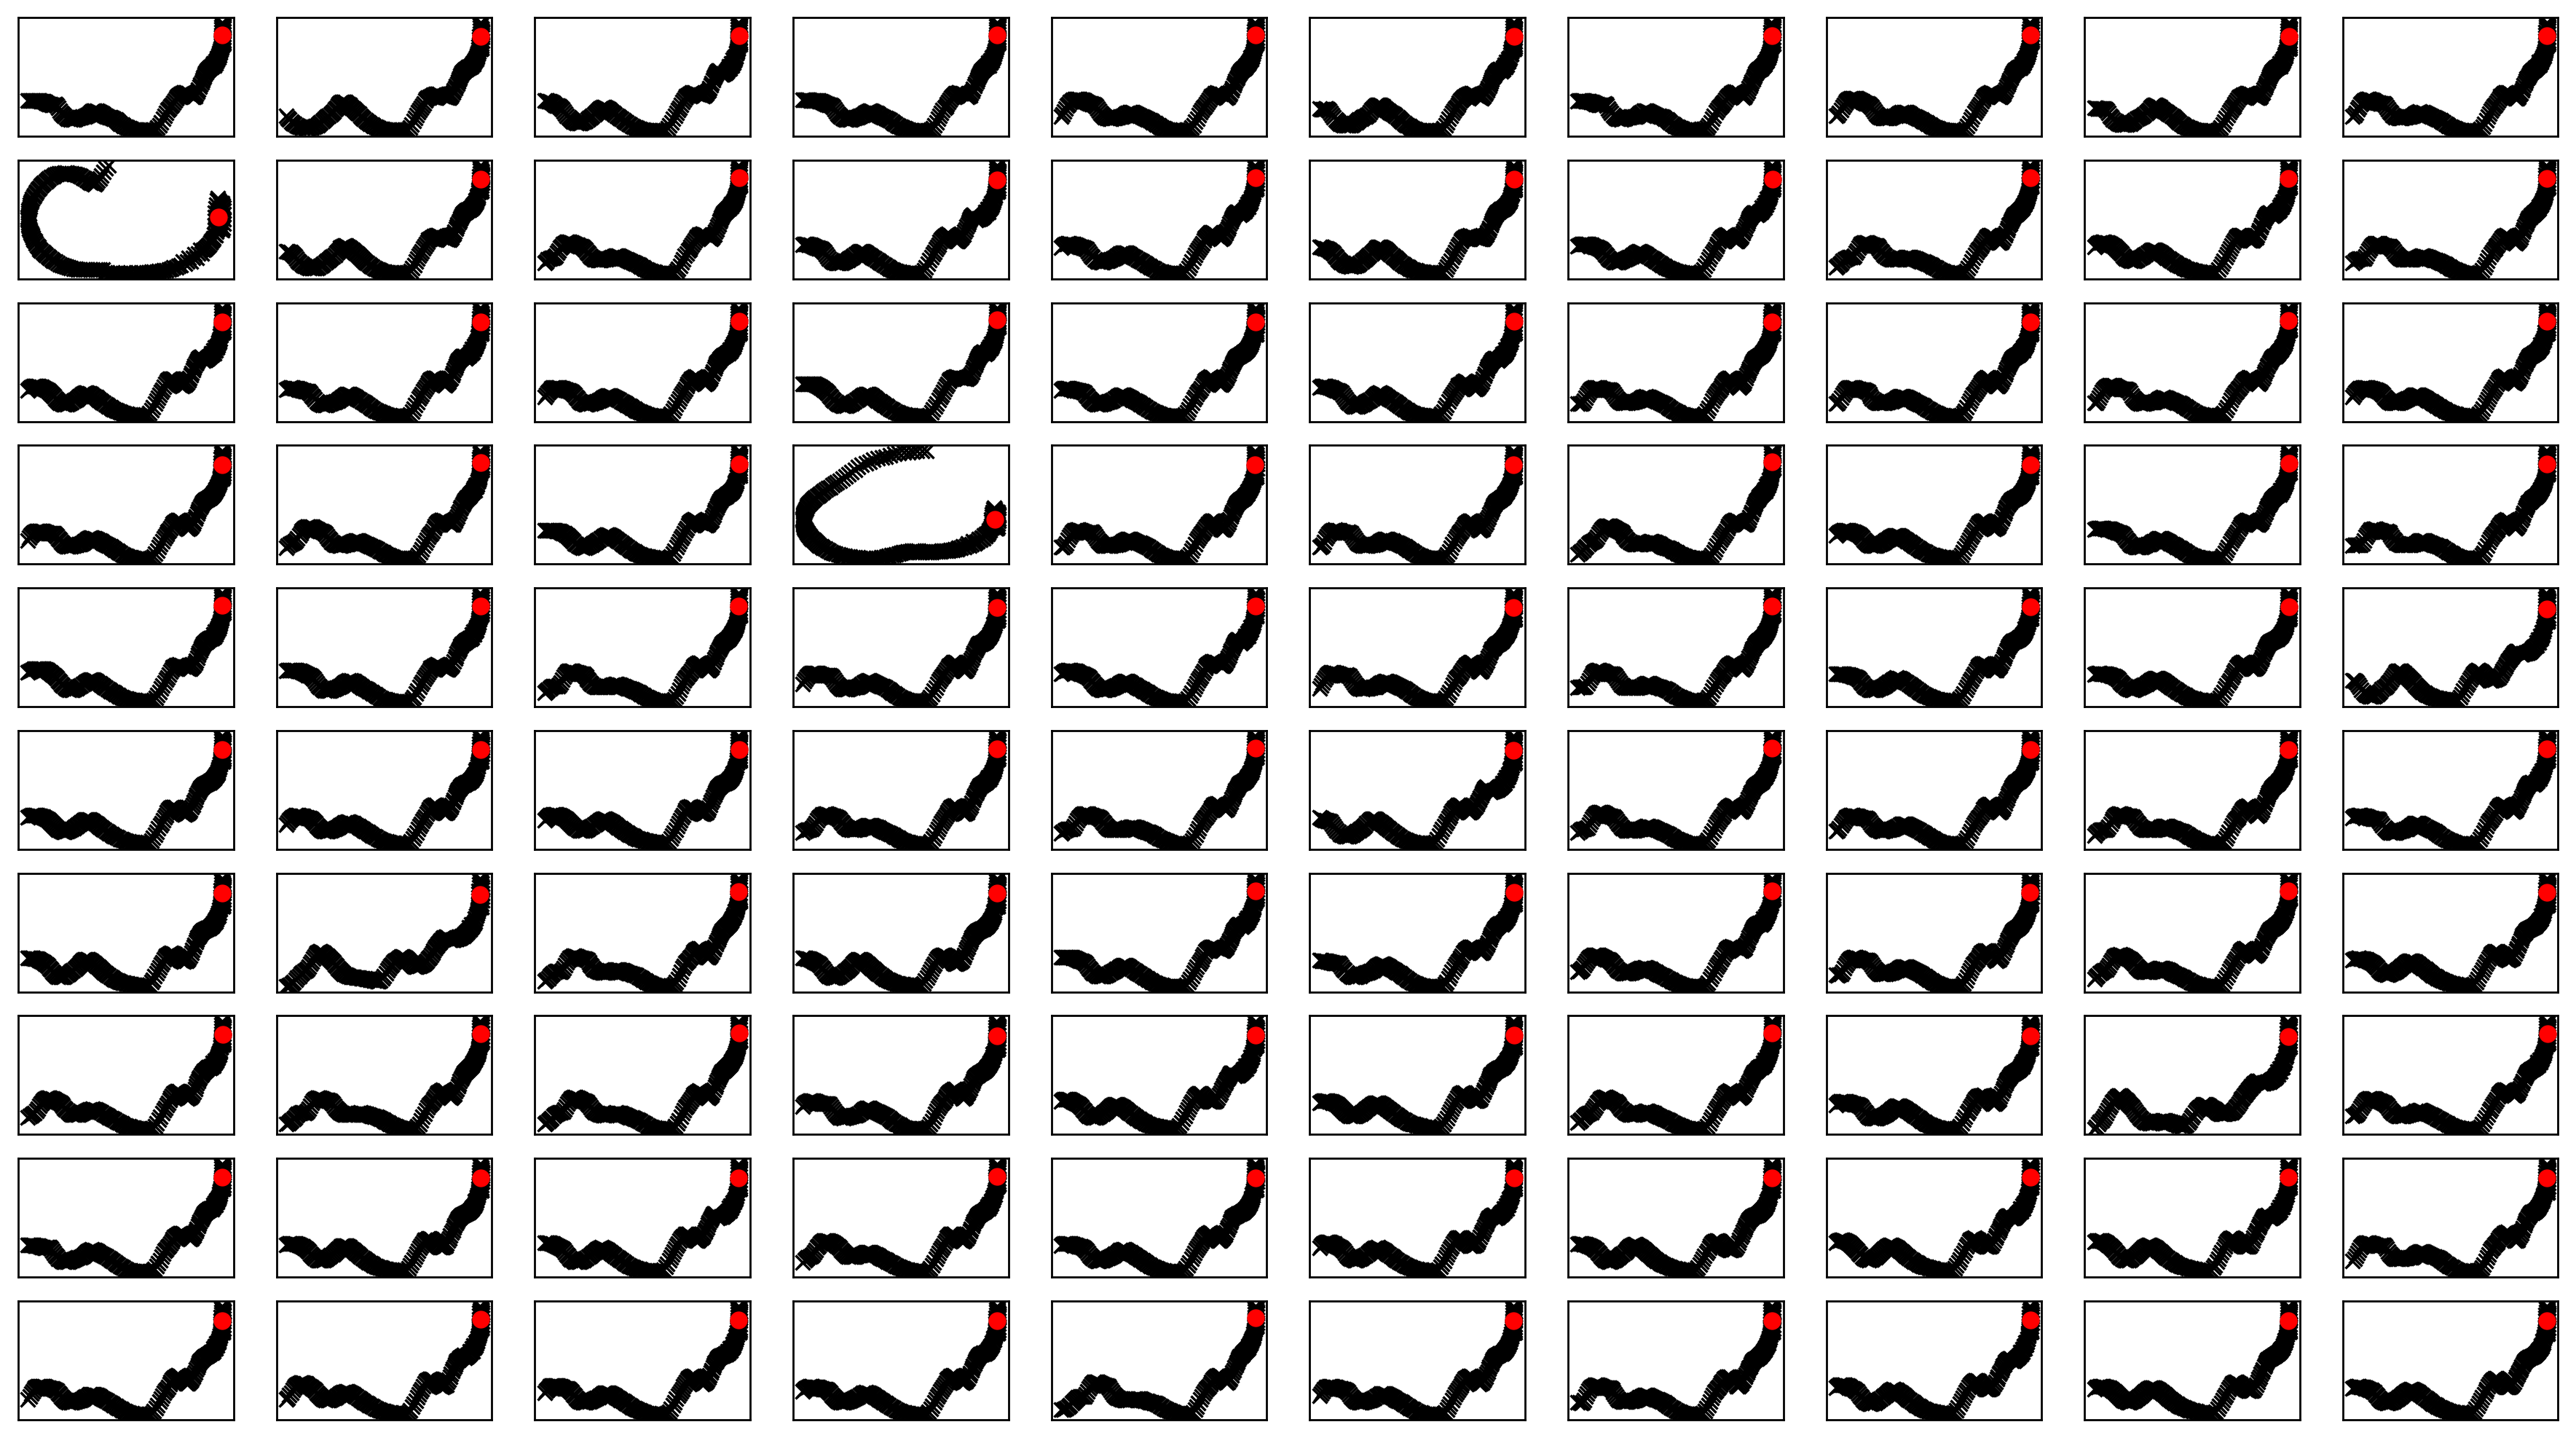

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

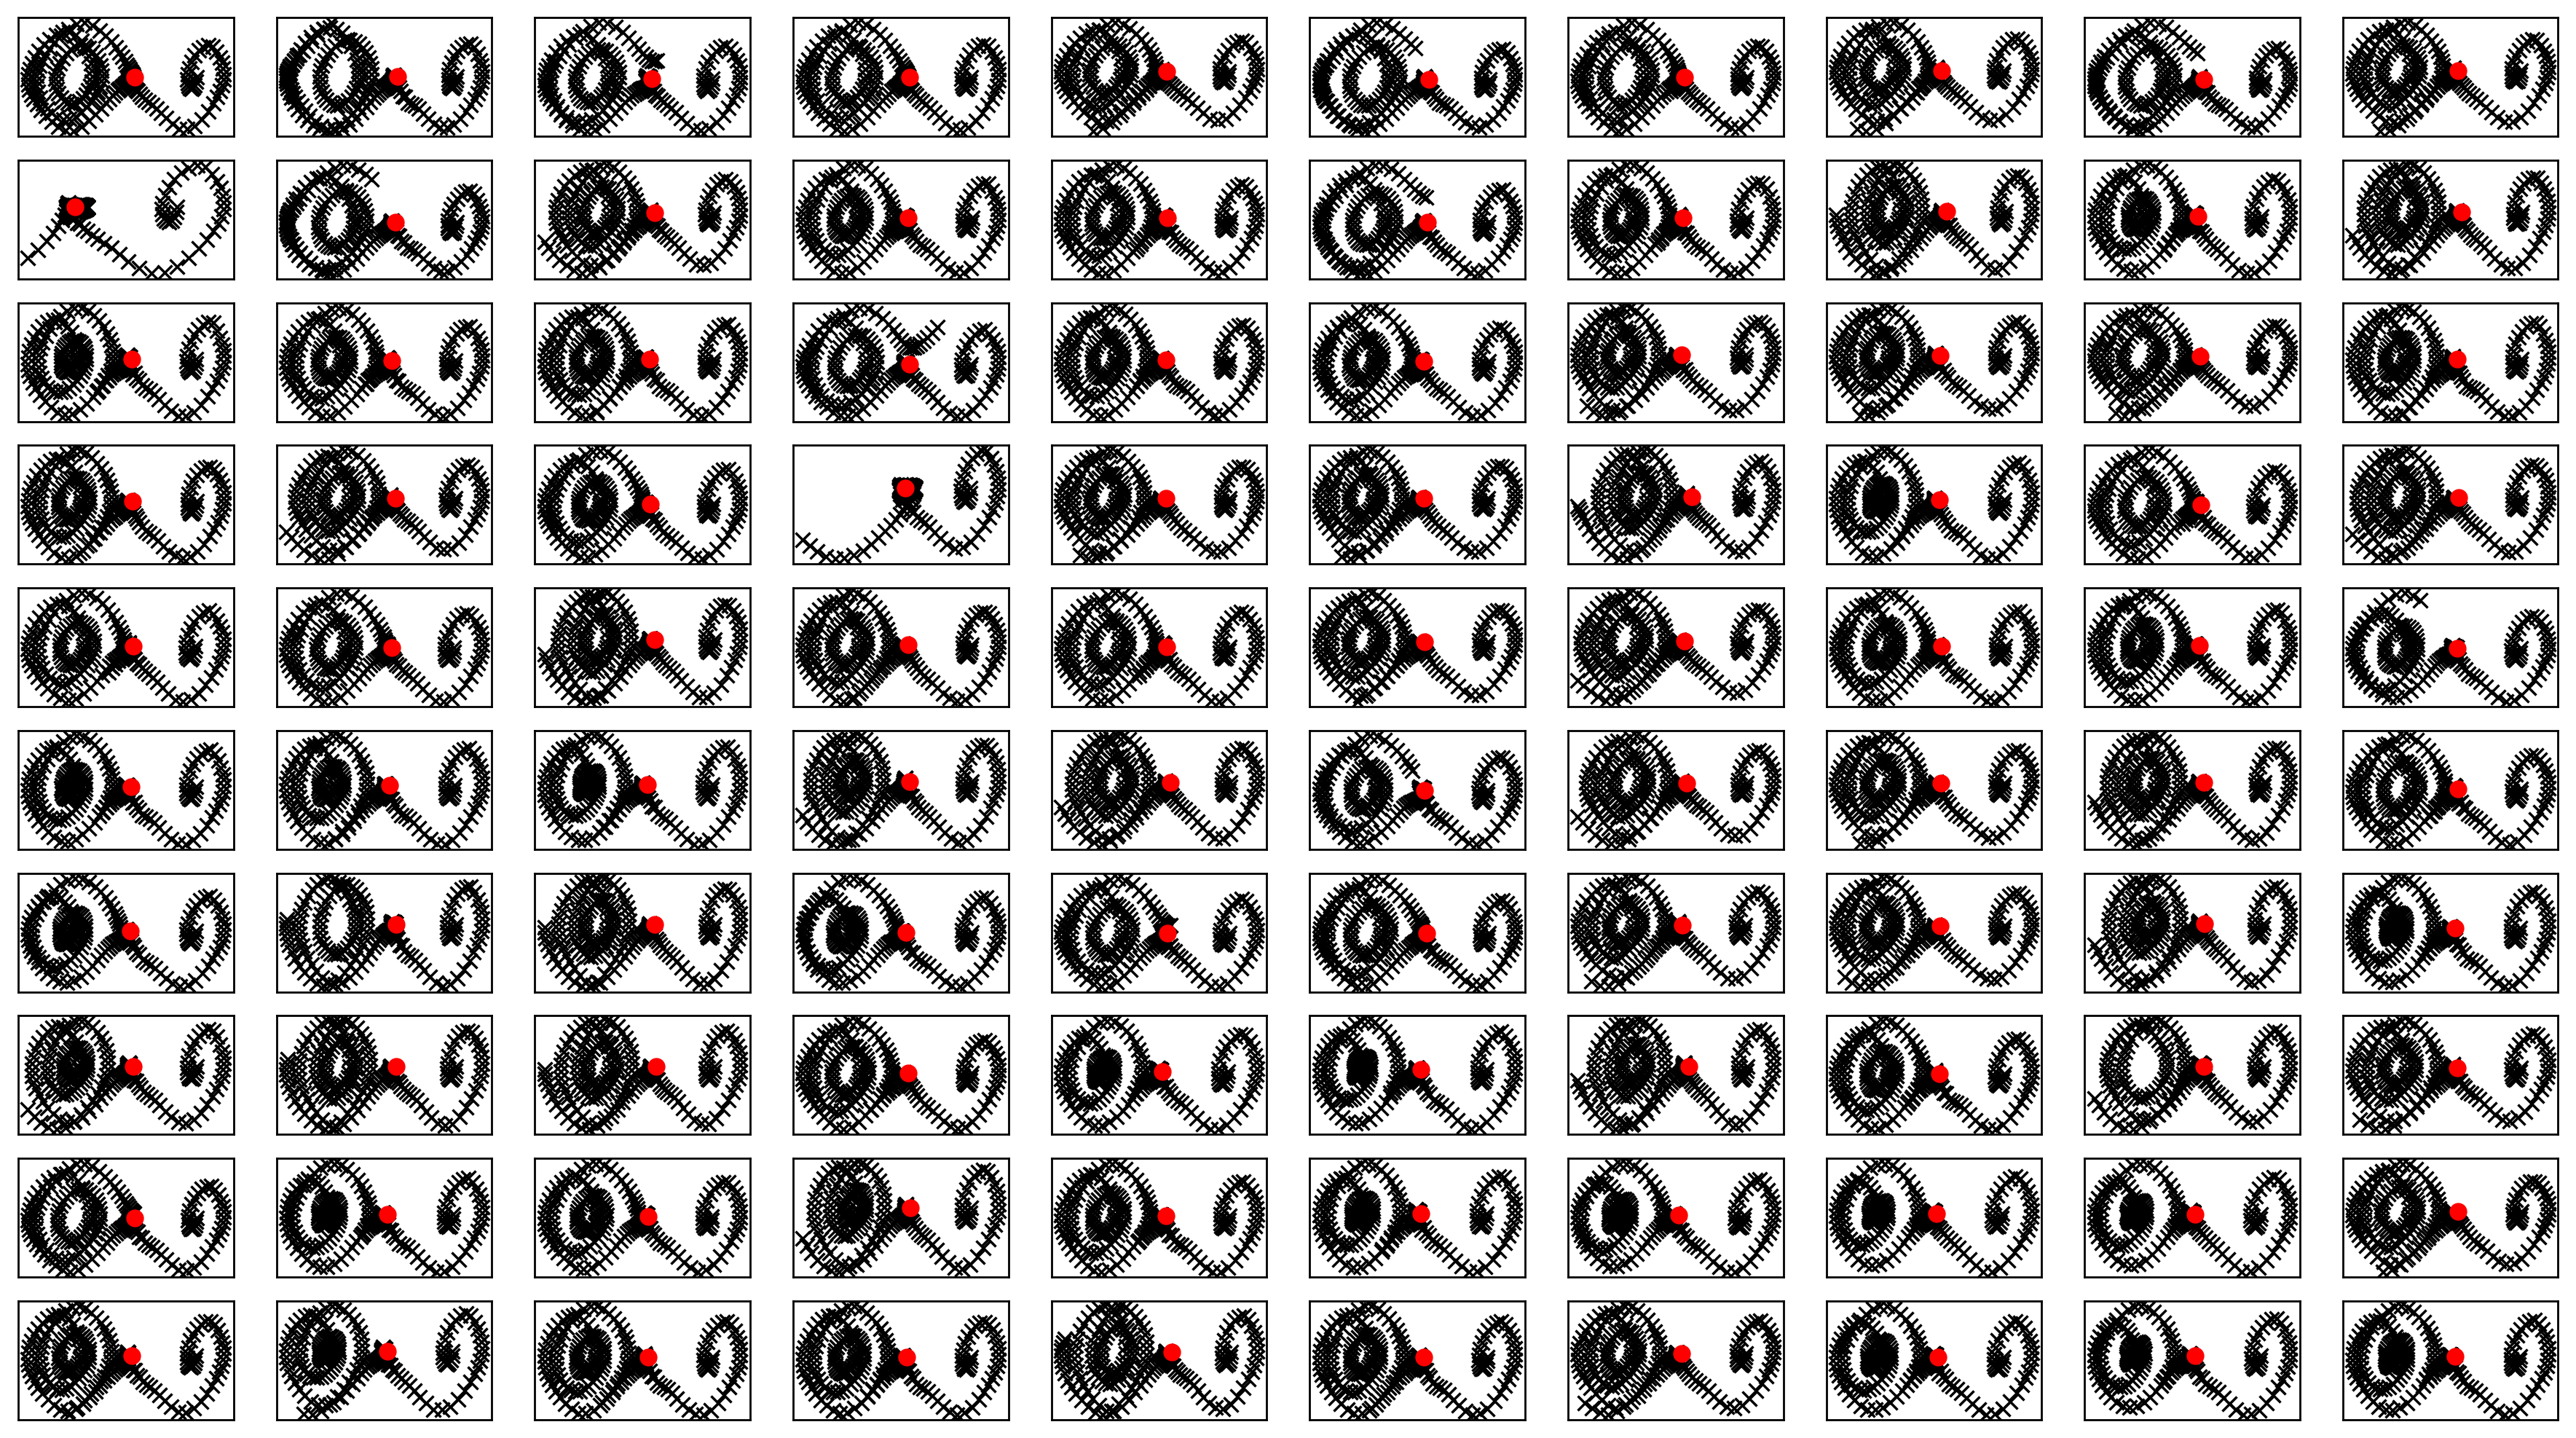

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-31 15:27:45.586920


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.35015  validloss 1.42633±0.00000  bestvalidloss 1.42633  last_update 0
train: iter 1  trainloss 1.24589  validloss 1.29428±0.00000  bestvalidloss 1.29428  last_update 0
train: iter 2  trainloss 1.10174  validloss 1.15642±0.00000  bestvalidloss 1.15642  last_update 0
train: iter 3  trainloss 0.94722  validloss 0.98638±0.00000  bestvalidloss 0.98638  last_update 0
train: iter 4  trainloss 0.83180  validloss 0.82365±0.00000  bestvalidloss 0.82365  last_update 0
train: iter 5  trainloss 0.75460  validloss 0.73021±0.00000  bestvalidloss 0.73021  last_update 0
train: iter 6  trainloss 0.70450  validloss 0.66487±0.00000  bestvalidloss 0.66487  last_update 0
train: iter 7  trainloss 0.66763  validloss 0.62257±0.00000  bestvalidloss 0.62257  last_update 0
train: iter 8  trainloss 0.64015  validloss 0.60285±0.00000  bestvalidloss 0.60285  last_update 0
train: iter 9  trainloss 0.61832  validloss 0.57247±0.00000  bestvalidloss 0.57247  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.38806  validloss 0.37609±0.00000  bestvalidloss 0.35749  last_update 2
train: iter 84  trainloss 0.39352  validloss 0.36782±0.00000  bestvalidloss 0.35749  last_update 3
train: iter 85  trainloss 0.37921  validloss 0.35593±0.00000  bestvalidloss 0.35593  last_update 0
train: iter 86  trainloss 0.38789  validloss 0.40219±0.00000  bestvalidloss 0.35593  last_update 1
train: iter 87  trainloss 0.38864  validloss 0.40340±0.00000  bestvalidloss 0.35593  last_update 2
train: iter 88  trainloss 0.38203  validloss 0.43806±0.00000  bestvalidloss 0.35593  last_update 3
train: iter 89  trainloss 0.38447  validloss 0.35948±0.00000  bestvalidloss 0.35593  last_update 4
train: iter 90  trainloss 0.38281  validloss 0.35605±0.00000  bestvalidloss 0.35593  last_update 5
train: iter 91  trainloss 0.36955  validloss 0.35180±0.00000  bestvalidloss 0.35180  last_update 0
train: iter 92  trainloss 0.37179  validloss 0.34847±0.00000  bestvalidloss 0.34847  last_update 0
train: ite

train: iter 166  trainloss 0.33396  validloss 0.32404±0.00000  bestvalidloss 0.31877  last_update 3
train: iter 167  trainloss 0.32946  validloss 0.33173±0.00000  bestvalidloss 0.31877  last_update 4
train: iter 168  trainloss 0.33381  validloss 0.32310±0.00000  bestvalidloss 0.31877  last_update 5
train: iter 169  trainloss 0.33084  validloss 0.32632±0.00000  bestvalidloss 0.31877  last_update 6
train: iter 170  trainloss 0.32690  validloss 0.32641±0.00000  bestvalidloss 0.31877  last_update 7
train: iter 171  trainloss 0.32811  validloss 0.32210±0.00000  bestvalidloss 0.31877  last_update 8
train: iter 172  trainloss 0.32745  validloss 0.31788±0.00000  bestvalidloss 0.31788  last_update 0
train: iter 173  trainloss 0.33146  validloss 0.32128±0.00000  bestvalidloss 0.31788  last_update 1
train: iter 174  trainloss 0.32474  validloss 0.31803±0.00000  bestvalidloss 0.31788  last_update 2
train: iter 175  trainloss 0.32714  validloss 0.31766±0.00000  bestvalidloss 0.31766  last_update 0


train: iter 248  trainloss 0.31250  validloss 0.31218±0.00000  bestvalidloss 0.29857  last_update 6
train: iter 249  trainloss 0.31123  validloss 0.30713±0.00000  bestvalidloss 0.29857  last_update 7
train: iter 250  trainloss 0.30671  validloss 0.30024±0.00000  bestvalidloss 0.29857  last_update 8
train: iter 251  trainloss 0.30691  validloss 0.32617±0.00000  bestvalidloss 0.29857  last_update 9
train: iter 252  trainloss 0.30795  validloss 0.35196±0.00000  bestvalidloss 0.29857  last_update 10
train: iter 253  trainloss 0.31205  validloss 0.30069±0.00000  bestvalidloss 0.29857  last_update 11
train: iter 254  trainloss 0.30450  validloss 0.31111±0.00000  bestvalidloss 0.29857  last_update 12
train: iter 255  trainloss 0.30452  validloss 0.30315±0.00000  bestvalidloss 0.29857  last_update 13
train: iter 256  trainloss 0.30831  validloss 0.31604±0.00000  bestvalidloss 0.29857  last_update 14
train: iter 257  trainloss 0.31429  validloss 0.30206±0.00000  bestvalidloss 0.29857  last_upda

train: iter 330  trainloss 0.28690  validloss 0.29437±0.00000  bestvalidloss 0.29064  last_update 6
train: iter 331  trainloss 0.28825  validloss 0.28815±0.00000  bestvalidloss 0.28815  last_update 0
train: iter 332  trainloss 0.29077  validloss 0.30702±0.00000  bestvalidloss 0.28815  last_update 1
train: iter 333  trainloss 0.29284  validloss 0.31880±0.00000  bestvalidloss 0.28815  last_update 2
train: iter 334  trainloss 0.28727  validloss 0.28928±0.00000  bestvalidloss 0.28815  last_update 3
train: iter 335  trainloss 0.28631  validloss 0.28951±0.00000  bestvalidloss 0.28815  last_update 4
train: iter 336  trainloss 0.29122  validloss 0.30292±0.00000  bestvalidloss 0.28815  last_update 5
train: iter 337  trainloss 0.28954  validloss 0.29156±0.00000  bestvalidloss 0.28815  last_update 6
train: iter 338  trainloss 0.29152  validloss 0.30567±0.00000  bestvalidloss 0.28815  last_update 7
train: iter 339  trainloss 0.28374  validloss 0.29096±0.00000  bestvalidloss 0.28815  last_update 8


train: iter 412  trainloss 0.27976  validloss 0.28554±0.00000  bestvalidloss 0.28268  last_update 1
train: iter 413  trainloss 0.27895  validloss 0.28614±0.00000  bestvalidloss 0.28268  last_update 2
train: iter 414  trainloss 0.27873  validloss 0.29108±0.00000  bestvalidloss 0.28268  last_update 3
train: iter 415  trainloss 0.27540  validloss 0.28329±0.00000  bestvalidloss 0.28268  last_update 4
train: iter 416  trainloss 0.27319  validloss 0.29474±0.00000  bestvalidloss 0.28268  last_update 5
train: iter 417  trainloss 0.27970  validloss 0.28291±0.00000  bestvalidloss 0.28268  last_update 6
train: iter 418  trainloss 0.27676  validloss 0.28627±0.00000  bestvalidloss 0.28268  last_update 7
train: iter 419  trainloss 0.27724  validloss 0.28906±0.00000  bestvalidloss 0.28268  last_update 8
train: iter 420  trainloss 0.27624  validloss 0.28263±0.00000  bestvalidloss 0.28263  last_update 0
train: iter 421  trainloss 0.27531  validloss 0.28672±0.00000  bestvalidloss 0.28263  last_update 1


train: iter 494  trainloss 0.27277  validloss 0.28984±0.00000  bestvalidloss 0.28040  last_update 29
train: iter 495  trainloss 0.26553  validloss 0.28435±0.00000  bestvalidloss 0.28040  last_update 30
train: iter 496  trainloss 0.26637  validloss 0.28183±0.00000  bestvalidloss 0.28040  last_update 31
train: iter 497  trainloss 0.26504  validloss 0.29051±0.00000  bestvalidloss 0.28040  last_update 32
train: iter 498  trainloss 0.27239  validloss 0.28400±0.00000  bestvalidloss 0.28040  last_update 33
train: iter 499  trainloss 0.26791  validloss 0.28902±0.00000  bestvalidloss 0.28040  last_update 34
train: iter 500  trainloss 0.26415  validloss 0.28592±0.00000  bestvalidloss 0.28040  last_update 35
train: iter 501  trainloss 0.26551  validloss 0.28046±0.00000  bestvalidloss 0.28040  last_update 36
train: iter 502  trainloss 0.26508  validloss 0.28378±0.00000  bestvalidloss 0.28040  last_update 37
train: iter 503  trainloss 0.26236  validloss 0.29261±0.00000  bestvalidloss 0.28040  last_

train: iter 576  trainloss 0.25417  validloss 0.28447±0.00000  bestvalidloss 0.27754  last_update 4
train: iter 577  trainloss 0.25992  validloss 0.28453±0.00000  bestvalidloss 0.27754  last_update 5
train: iter 578  trainloss 0.25446  validloss 0.28251±0.00000  bestvalidloss 0.27754  last_update 6
train: iter 579  trainloss 0.25587  validloss 0.27641±0.00000  bestvalidloss 0.27641  last_update 0
train: iter 580  trainloss 0.25402  validloss 0.27796±0.00000  bestvalidloss 0.27641  last_update 1
train: iter 581  trainloss 0.25126  validloss 0.27979±0.00000  bestvalidloss 0.27641  last_update 2
train: iter 582  trainloss 0.25383  validloss 0.28594±0.00000  bestvalidloss 0.27641  last_update 3
train: iter 583  trainloss 0.25617  validloss 0.28333±0.00000  bestvalidloss 0.27641  last_update 4
train: iter 584  trainloss 0.26204  validloss 0.27792±0.00000  bestvalidloss 0.27641  last_update 5
train: iter 585  trainloss 0.25970  validloss 0.28679±0.00000  bestvalidloss 0.27641  last_update 6


train: iter 658  trainloss 0.24666  validloss 0.28544±0.00000  bestvalidloss 0.27155  last_update 29
train: iter 659  trainloss 0.24845  validloss 0.28037±0.00000  bestvalidloss 0.27155  last_update 30
train: iter 660  trainloss 0.25304  validloss 0.27984±0.00000  bestvalidloss 0.27155  last_update 31
train: iter 661  trainloss 0.24985  validloss 0.27497±0.00000  bestvalidloss 0.27155  last_update 32
train: iter 662  trainloss 0.24815  validloss 0.28132±0.00000  bestvalidloss 0.27155  last_update 33
train: iter 663  trainloss 0.24615  validloss 0.27415±0.00000  bestvalidloss 0.27155  last_update 34
train: iter 664  trainloss 0.24735  validloss 0.27533±0.00000  bestvalidloss 0.27155  last_update 35
train: iter 665  trainloss 0.24864  validloss 0.27793±0.00000  bestvalidloss 0.27155  last_update 36
train: iter 666  trainloss 0.24449  validloss 0.27640±0.00000  bestvalidloss 0.27155  last_update 37
train: iter 667  trainloss 0.24671  validloss 0.29636±0.00000  bestvalidloss 0.27155  last_

train: iter 740  trainloss 0.23925  validloss 0.27488±0.00000  bestvalidloss 0.27090  last_update 50
train: iter 741  trainloss 0.24274  validloss 0.27563±0.00000  bestvalidloss 0.27090  last_update 51
train: iter 742  trainloss 0.24256  validloss 0.27657±0.00000  bestvalidloss 0.27090  last_update 52
train: iter 743  trainloss 0.24174  validloss 0.27600±0.00000  bestvalidloss 0.27090  last_update 53
train: iter 744  trainloss 0.24112  validloss 0.29007±0.00000  bestvalidloss 0.27090  last_update 54
train: iter 745  trainloss 0.23868  validloss 0.28718±0.00000  bestvalidloss 0.27090  last_update 55
train: iter 746  trainloss 0.23811  validloss 0.27820±0.00000  bestvalidloss 0.27090  last_update 56
train: iter 747  trainloss 0.24062  validloss 0.27600±0.00000  bestvalidloss 0.27090  last_update 57
train: iter 748  trainloss 0.23992  validloss 0.27768±0.00000  bestvalidloss 0.27090  last_update 58
train: iter 749  trainloss 0.24161  validloss 0.27411±0.00000  bestvalidloss 0.27090  last_

train: iter 822  trainloss 0.23491  validloss 0.27557±0.00000  bestvalidloss 0.26689  last_update 47
train: iter 823  trainloss 0.23174  validloss 0.26964±0.00000  bestvalidloss 0.26689  last_update 48
train: iter 824  trainloss 0.23618  validloss 0.27413±0.00000  bestvalidloss 0.26689  last_update 49
train: iter 825  trainloss 0.23474  validloss 0.27579±0.00000  bestvalidloss 0.26689  last_update 50
train: iter 826  trainloss 0.23496  validloss 0.26899±0.00000  bestvalidloss 0.26689  last_update 51
train: iter 827  trainloss 0.23584  validloss 0.26750±0.00000  bestvalidloss 0.26689  last_update 52
train: iter 828  trainloss 0.23506  validloss 0.27224±0.00000  bestvalidloss 0.26689  last_update 53
train: iter 829  trainloss 0.23136  validloss 0.26995±0.00000  bestvalidloss 0.26689  last_update 54
train: iter 830  trainloss 0.23565  validloss 0.26693±0.00000  bestvalidloss 0.26689  last_update 55
train: iter 831  trainloss 0.23810  validloss 0.26878±0.00000  bestvalidloss 0.26689  last_

train: iter 904  trainloss 0.22456  validloss 0.26513±0.00000  bestvalidloss 0.26376  last_update 34
train: iter 905  trainloss 0.22988  validloss 0.26443±0.00000  bestvalidloss 0.26376  last_update 35
train: iter 906  trainloss 0.22770  validloss 0.28076±0.00000  bestvalidloss 0.26376  last_update 36
train: iter 907  trainloss 0.22793  validloss 0.27445±0.00000  bestvalidloss 0.26376  last_update 37
train: iter 908  trainloss 0.22595  validloss 0.27022±0.00000  bestvalidloss 0.26376  last_update 38
train: iter 909  trainloss 0.22700  validloss 0.26778±0.00000  bestvalidloss 0.26376  last_update 39
train: iter 910  trainloss 0.22774  validloss 0.27839±0.00000  bestvalidloss 0.26376  last_update 40
train: iter 911  trainloss 0.22998  validloss 0.27641±0.00000  bestvalidloss 0.26376  last_update 41
train: iter 912  trainloss 0.22656  validloss 0.26396±0.00000  bestvalidloss 0.26376  last_update 42
train: iter 913  trainloss 0.23163  validloss 0.27432±0.00000  bestvalidloss 0.26376  last_

train: iter 986  trainloss 0.22167  validloss 0.26385±0.00000  bestvalidloss 0.26095  last_update 12
train: iter 987  trainloss 0.22547  validloss 0.26771±0.00000  bestvalidloss 0.26095  last_update 13
train: iter 988  trainloss 0.22350  validloss 0.26345±0.00000  bestvalidloss 0.26095  last_update 14
train: iter 989  trainloss 0.22568  validloss 0.27174±0.00000  bestvalidloss 0.26095  last_update 15
train: iter 990  trainloss 0.22089  validloss 0.26412±0.00000  bestvalidloss 0.26095  last_update 16
train: iter 991  trainloss 0.22359  validloss 0.27414±0.00000  bestvalidloss 0.26095  last_update 17
train: iter 992  trainloss 0.21930  validloss 0.26672±0.00000  bestvalidloss 0.26095  last_update 18
train: iter 993  trainloss 0.22568  validloss 0.28237±0.00000  bestvalidloss 0.26095  last_update 19
train: iter 994  trainloss 0.22451  validloss 0.26958±0.00000  bestvalidloss 0.26095  last_update 20
train: iter 995  trainloss 0.22501  validloss 0.26060±0.00000  bestvalidloss 0.26060  last_

train: iter 1067  trainloss 0.21908  validloss 0.26292±0.00000  bestvalidloss 0.26060  last_update 72
train: iter 1068  trainloss 0.21560  validloss 0.26893±0.00000  bestvalidloss 0.26060  last_update 73
train: iter 1069  trainloss 0.21611  validloss 0.26559±0.00000  bestvalidloss 0.26060  last_update 74
train: iter 1070  trainloss 0.21630  validloss 0.26861±0.00000  bestvalidloss 0.26060  last_update 75
train: iter 1071  trainloss 0.21974  validloss 0.26481±0.00000  bestvalidloss 0.26060  last_update 76
train: iter 1072  trainloss 0.21739  validloss 0.26223±0.00000  bestvalidloss 0.26060  last_update 77
train: iter 1073  trainloss 0.21674  validloss 0.27254±0.00000  bestvalidloss 0.26060  last_update 78
train: iter 1074  trainloss 0.22026  validloss 0.26617±0.00000  bestvalidloss 0.26060  last_update 79
train: iter 1075  trainloss 0.21849  validloss 0.27484±0.00000  bestvalidloss 0.26060  last_update 80
train: iter 1076  trainloss 0.22058  validloss 0.27349±0.00000  bestvalidloss 0.26

train_loss:  -2.629388362431526
valid_loss:  -4.00992384274006
weight_alpha 1.0 h_min_tilde -11.622948 ell_tilde -2.905495458493233 kappa_tilde 0.0003386922130452702
train_loss:  -2.7506029480934147
valid_loss:  -2.6226939453124998
weight_alpha 0.1 h_min_tilde -11.622948 ell_tilde -2.7250211475372317 kappa_tilde 0.00033523981466956703


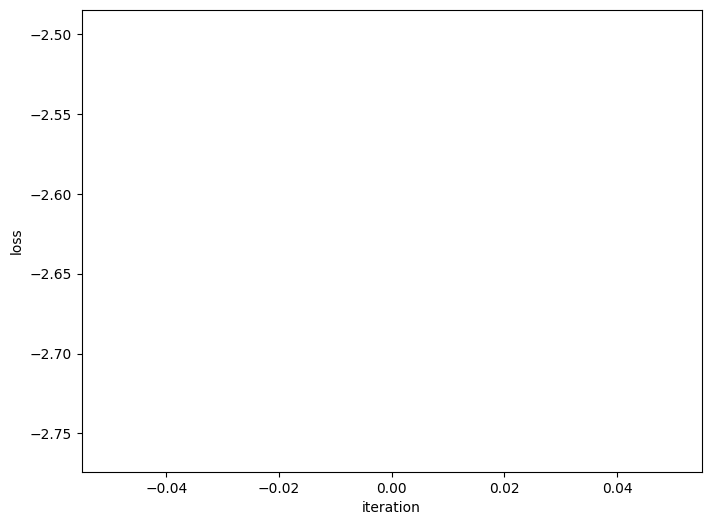

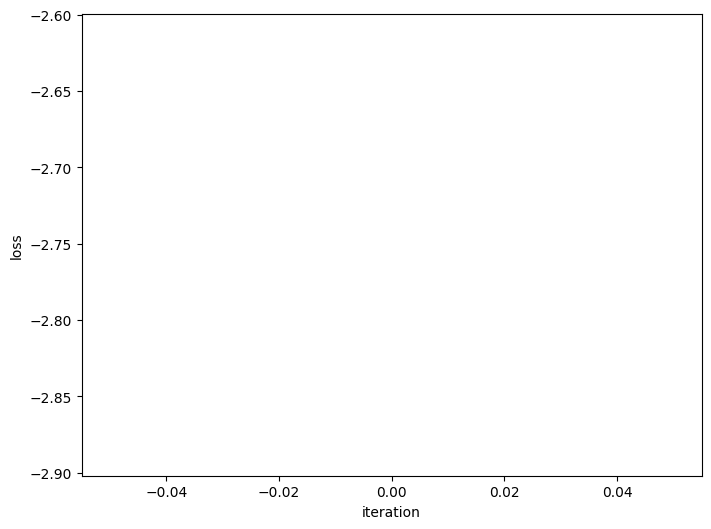

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -520.98195  validloss -525.50031±0.00000  bestvalidloss -525.50031  last_update 0
train: iter 1  trainloss -536.06515  validloss -515.18164±0.00000  bestvalidloss -525.50031  last_update 1
train: iter 2  trainloss -534.29599  validloss -491.95118±0.00000  bestvalidloss -525.50031  last_update 2
train: iter 3  trainloss -542.96340  validloss -505.78832±0.00000  bestvalidloss -525.50031  last_update 3
train: iter 4  trainloss -537.07870  validloss -527.80710±0.00000  bestvalidloss -527.80710  last_update 0
train: iter 5  trainloss -523.08323  validloss -486.33587±0.00000  bestvalidloss -527.80710  last_update 1
train: iter 6  trainloss -535.43671  validloss -500.18652±0.00000  bestvalidloss -527.80710  last_update 2
train: iter 7  trainloss -512.63209  validloss -500.02579±0.00000  bestvalidloss -527.80710  last_update 3
train: iter 8  trainloss -530.70265  validloss -507.32965±0.00000  bestvalidloss -527.80710  last_u

train: iter 75  trainloss -490.07849  validloss -503.90676±0.00000  bestvalidloss -527.80710  last_update 71
train: iter 76  trainloss -462.18402  validloss -421.72596±0.00000  bestvalidloss -527.80710  last_update 72
train: iter 77  trainloss -518.77854  validloss -469.46306±0.00000  bestvalidloss -527.80710  last_update 73
train: iter 78  trainloss -529.94259  validloss -487.08319±0.00000  bestvalidloss -527.80710  last_update 74
train: iter 79  trainloss -531.52101  validloss -499.74374±0.00000  bestvalidloss -527.80710  last_update 75
train: iter 80  trainloss -534.83874  validloss -478.02726±0.00000  bestvalidloss -527.80710  last_update 76
train: iter 81  trainloss -526.67656  validloss -482.83842±0.00000  bestvalidloss -527.80710  last_update 77
train: iter 82  trainloss -491.37089  validloss -492.49871±0.00000  bestvalidloss -527.80710  last_update 78
train: iter 83  trainloss -519.51569  validloss -450.39694±0.00000  bestvalidloss -527.80710  last_update 79
train: iter 84  tra

train: iter 150  trainloss -507.58130  validloss -447.35206±0.00000  bestvalidloss -537.64305  last_update 52
train: iter 151  trainloss -516.29999  validloss -481.04589±0.00000  bestvalidloss -537.64305  last_update 53
train: iter 152  trainloss -525.32240  validloss -483.60004±0.00000  bestvalidloss -537.64305  last_update 54
train: iter 153  trainloss -519.85175  validloss -470.46878±0.00000  bestvalidloss -537.64305  last_update 55
train: iter 154  trainloss -514.83767  validloss -490.17064±0.00000  bestvalidloss -537.64305  last_update 56
train: iter 155  trainloss -531.58133  validloss -497.82034±0.00000  bestvalidloss -537.64305  last_update 57
train: iter 156  trainloss -517.31995  validloss -484.54848±0.00000  bestvalidloss -537.64305  last_update 58
train: iter 157  trainloss -521.23825  validloss -490.32803±0.00000  bestvalidloss -537.64305  last_update 59
train: iter 158  trainloss -516.61340  validloss -481.52319±0.00000  bestvalidloss -537.64305  last_update 60
train: ite

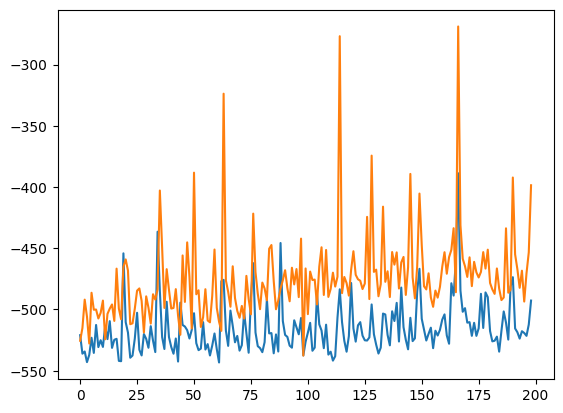

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-31 15:55:46.193429


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.47769  validloss 1.17245±0.00000  bestvalidloss 1.17245  last_update 0
train: iter 1  trainloss 0.38209  validloss 0.39696±0.00000  bestvalidloss 0.39696  last_update 0
train: iter 2  trainloss 0.36126  validloss 0.36342±0.00000  bestvalidloss 0.36342  last_update 0
train: iter 3  trainloss 0.34853  validloss 0.37508±0.00000  bestvalidloss 0.36342  last_update 1
train: iter 4  trainloss 0.33945  validloss 0.36107±0.00000  bestvalidloss 0.36107  last_update 0
train: iter 5  trainloss 0.33722  validloss 0.35063±0.00000  bestvalidloss 0.35063  last_update 0
train: iter 6  trainloss 0.33286  validloss 0.34309±0.00000  bestvalidloss 0.34309  last_update 0
train: iter 7  trainloss 0.32813  validloss 0.34497±0.00000  bestvalidloss 0.34309  last_update 1
train: iter 8  trainloss 0.32810  validloss 0.34186±0.00000  bestvalidloss 0.34186  last_update 0
train: iter 9  trainloss 0.32215  validloss 0.32982±0.00000  bestvalidloss 0.32982  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.28021  validloss 0.30155±0.00000  bestvalidloss 0.29706  last_update 21
train: iter 84  trainloss 0.28162  validloss 0.30596±0.00000  bestvalidloss 0.29706  last_update 22
train: iter 85  trainloss 0.27868  validloss 0.30215±0.00000  bestvalidloss 0.29706  last_update 23
train: iter 86  trainloss 0.27660  validloss 0.30566±0.00000  bestvalidloss 0.29706  last_update 24
train: iter 87  trainloss 0.28576  validloss 0.33059±0.00000  bestvalidloss 0.29706  last_update 25
train: iter 88  trainloss 0.27802  validloss 0.30369±0.00000  bestvalidloss 0.29706  last_update 26
train: iter 89  trainloss 0.27583  validloss 0.29913±0.00000  bestvalidloss 0.29706  last_update 27
train: iter 90  trainloss 0.27934  validloss 0.29489±0.00000  bestvalidloss 0.29489  last_update 0
train: iter 91  trainloss 0.27953  validloss 0.31800±0.00000  bestvalidloss 0.29489  last_update 1
train: iter 92  trainloss 0.27497  validloss 0.31016±0.00000  bestvalidloss 0.29489  last_update 2
tra

train: iter 165  trainloss 0.27417  validloss 0.34880±0.00000  bestvalidloss 0.29186  last_update 17
train: iter 166  trainloss 0.27704  validloss 0.28217±0.00000  bestvalidloss 0.28217  last_update 0
train: iter 167  trainloss 0.26876  validloss 0.29528±0.00000  bestvalidloss 0.28217  last_update 1
train: iter 168  trainloss 0.26673  validloss 0.28991±0.00000  bestvalidloss 0.28217  last_update 2
train: iter 169  trainloss 0.26584  validloss 0.29524±0.00000  bestvalidloss 0.28217  last_update 3
train: iter 170  trainloss 0.26984  validloss 0.28812±0.00000  bestvalidloss 0.28217  last_update 4
train: iter 171  trainloss 0.26352  validloss 0.30445±0.00000  bestvalidloss 0.28217  last_update 5
train: iter 172  trainloss 0.26291  validloss 0.30234±0.00000  bestvalidloss 0.28217  last_update 6
train: iter 173  trainloss 0.26550  validloss 0.29959±0.00000  bestvalidloss 0.28217  last_update 7
train: iter 174  trainloss 0.26575  validloss 0.29224±0.00000  bestvalidloss 0.28217  last_update 8

train: iter 247  trainloss 0.26723  validloss 0.33057±0.00000  bestvalidloss 0.28217  last_update 81
train: iter 248  trainloss 0.25684  validloss 0.31667±0.00000  bestvalidloss 0.28217  last_update 82
train: iter 249  trainloss 0.25696  validloss 0.28960±0.00000  bestvalidloss 0.28217  last_update 83
train: iter 250  trainloss 0.25493  validloss 0.28930±0.00000  bestvalidloss 0.28217  last_update 84
train: iter 251  trainloss 0.26134  validloss 0.28724±0.00000  bestvalidloss 0.28217  last_update 85
train: iter 252  trainloss 0.25614  validloss 0.28617±0.00000  bestvalidloss 0.28217  last_update 86
train: iter 253  trainloss 0.25883  validloss 0.28587±0.00000  bestvalidloss 0.28217  last_update 87
train: iter 254  trainloss 0.25561  validloss 0.28372±0.00000  bestvalidloss 0.28217  last_update 88
train: iter 255  trainloss 0.25773  validloss 0.28860±0.00000  bestvalidloss 0.28217  last_update 89
train: iter 256  trainloss 0.25356  validloss 0.29158±0.00000  bestvalidloss 0.28217  last_

train_loss:  -4.650511250329017
valid_loss:  -4.571419575738906
weight_alpha 1.0 h_min_tilde -11.573606 ell_tilde -4.634692915410995 kappa_tilde 0.00037962455046697626
train_loss:  -3.106515655899048
valid_loss:  -2.853107582473755
weight_alpha 0.1 h_min_tilde -11.573606 ell_tilde -3.0558340412139895 kappa_tilde 0.0003426391684481297


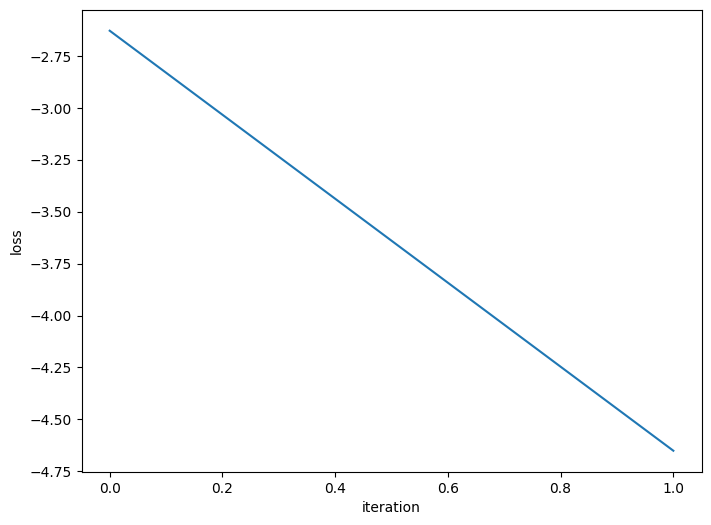

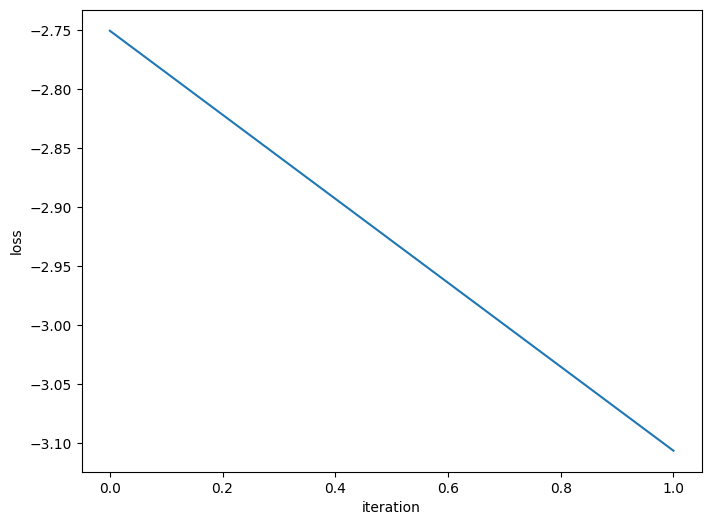

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -611.69454  validloss -574.11686±0.00000  bestvalidloss -574.11686  last_update 0
train: iter 1  trainloss -615.48087  validloss -562.28108±0.00000  bestvalidloss -574.11686  last_update 1
train: iter 2  trainloss -605.03115  validloss -524.03387±0.00000  bestvalidloss -574.11686  last_update 2
train: iter 3  trainloss -596.97384  validloss -560.46502±0.00000  bestvalidloss -574.11686  last_update 3
train: iter 4  trainloss -605.69592  validloss -481.52183±0.00000  bestvalidloss -574.11686  last_update 4
train: iter 5  trainloss -561.93447  validloss -524.75490±0.00000  bestvalidloss -574.11686  last_update 5
train: iter 6  trainloss -604.93725  validloss -524.97563±0.00000  bestvalidloss -574.11686  last_update 6
train: iter 7  trainloss -623.06211  validloss -572.21584±0.00000  bestvalidloss -574.11686  last_update 7
train: iter 8  trainloss -626.74071  validloss -568.64994±0.00000  bestvalidloss -574.11686  last_u

train: iter 76  trainloss -585.33126  validloss -555.10283±0.00000  bestvalidloss -577.61366  last_update 45
train: iter 77  trainloss -610.07439  validloss -534.94517±0.00000  bestvalidloss -577.61366  last_update 46
train: iter 78  trainloss -611.21879  validloss -537.50485±0.00000  bestvalidloss -577.61366  last_update 47
train: iter 79  trainloss -563.74973  validloss -466.04220±0.00000  bestvalidloss -577.61366  last_update 48
train: iter 80  trainloss -606.66627  validloss -513.80758±0.00000  bestvalidloss -577.61366  last_update 49
train: iter 81  trainloss -602.31978  validloss -550.80424±0.00000  bestvalidloss -577.61366  last_update 50
train: iter 82  trainloss -617.03889  validloss -552.91823±0.00000  bestvalidloss -577.61366  last_update 51
train: iter 83  trainloss -601.66603  validloss -566.71399±0.00000  bestvalidloss -577.61366  last_update 52
train: iter 84  trainloss -609.19619  validloss -521.29600±0.00000  bestvalidloss -577.61366  last_update 53
train: iter 85  tra

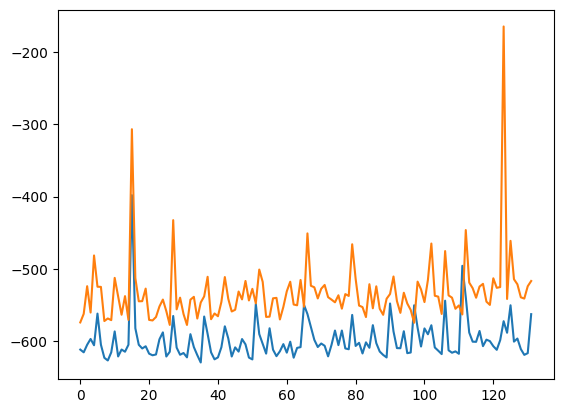

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-31 16:20:52.512589


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.35003  validloss 0.66278±0.00000  bestvalidloss 0.66278  last_update 0
train: iter 1  trainloss 0.33376  validloss 0.48360±0.00000  bestvalidloss 0.48360  last_update 0
train: iter 2  trainloss 0.32791  validloss 0.48556±0.00000  bestvalidloss 0.48360  last_update 1
train: iter 3  trainloss 0.32760  validloss 0.47410±0.00000  bestvalidloss 0.47410  last_update 0
train: iter 4  trainloss 0.32523  validloss 0.47759±0.00000  bestvalidloss 0.47410  last_update 1
train: iter 5  trainloss 0.32542  validloss 0.47480±0.00000  bestvalidloss 0.47410  last_update 2
train: iter 6  trainloss 0.31747  validloss 0.47136±0.00000  bestvalidloss 0.47136  last_update 0
train: iter 7  trainloss 0.31861  validloss 0.47521±0.00000  bestvalidloss 0.47136  last_update 1
train: iter 8  trainloss 0.32214  validloss 0.47887±0.00000  bestvalidloss 0.47136  last_update 2
train: iter 9  trainloss 0.32005  validloss 0.46969±0.00000  bestvalidloss 0.46969  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.29835  validloss 0.45565±0.00000  bestvalidloss 0.43771  last_update 10
train: iter 84  trainloss 0.29240  validloss 0.45395±0.00000  bestvalidloss 0.43771  last_update 11
train: iter 85  trainloss 0.29856  validloss 0.45047±0.00000  bestvalidloss 0.43771  last_update 12
train: iter 86  trainloss 0.29438  validloss 0.45265±0.00000  bestvalidloss 0.43771  last_update 13
train: iter 87  trainloss 0.29752  validloss 0.47058±0.00000  bestvalidloss 0.43771  last_update 14
train: iter 88  trainloss 0.29405  validloss 0.45062±0.00000  bestvalidloss 0.43771  last_update 15
train: iter 89  trainloss 0.29352  validloss 0.45125±0.00000  bestvalidloss 0.43771  last_update 16
train: iter 90  trainloss 0.29010  validloss 0.46361±0.00000  bestvalidloss 0.43771  last_update 17
train: iter 91  trainloss 0.29271  validloss 0.46099±0.00000  bestvalidloss 0.43771  last_update 18
train: iter 92  trainloss 0.29094  validloss 0.44963±0.00000  bestvalidloss 0.43771  last_update 19


train: iter 165  trainloss 0.28296  validloss 0.44541±0.00000  bestvalidloss 0.43400  last_update 15
train: iter 166  trainloss 0.28185  validloss 0.44053±0.00000  bestvalidloss 0.43400  last_update 16
train: iter 167  trainloss 0.28572  validloss 0.43465±0.00000  bestvalidloss 0.43400  last_update 17
train: iter 168  trainloss 0.28471  validloss 0.44293±0.00000  bestvalidloss 0.43400  last_update 18
train: iter 169  trainloss 0.28495  validloss 0.45524±0.00000  bestvalidloss 0.43400  last_update 19
train: iter 170  trainloss 0.28059  validloss 0.44089±0.00000  bestvalidloss 0.43400  last_update 20
train: iter 171  trainloss 0.28907  validloss 0.46056±0.00000  bestvalidloss 0.43400  last_update 21
train: iter 172  trainloss 0.28353  validloss 0.44192±0.00000  bestvalidloss 0.43400  last_update 22
train: iter 173  trainloss 0.28523  validloss 0.45067±0.00000  bestvalidloss 0.43400  last_update 23
train: iter 174  trainloss 0.28276  validloss 0.43310±0.00000  bestvalidloss 0.43310  last_

train: iter 247  trainloss 0.27550  validloss 0.43575±0.00000  bestvalidloss 0.43310  last_update 73
train: iter 248  trainloss 0.27447  validloss 0.44948±0.00000  bestvalidloss 0.43310  last_update 74
train: iter 249  trainloss 0.27173  validloss 0.44951±0.00000  bestvalidloss 0.43310  last_update 75
train: iter 250  trainloss 0.26965  validloss 0.43271±0.00000  bestvalidloss 0.43271  last_update 0
train: iter 251  trainloss 0.27397  validloss 0.47887±0.00000  bestvalidloss 0.43271  last_update 1
train: iter 252  trainloss 0.27033  validloss 0.45161±0.00000  bestvalidloss 0.43271  last_update 2
train: iter 253  trainloss 0.27340  validloss 0.45027±0.00000  bestvalidloss 0.43271  last_update 3
train: iter 254  trainloss 0.27289  validloss 0.43696±0.00000  bestvalidloss 0.43271  last_update 4
train: iter 255  trainloss 0.27480  validloss 0.46355±0.00000  bestvalidloss 0.43271  last_update 5
train: iter 256  trainloss 0.27080  validloss 0.45631±0.00000  bestvalidloss 0.43271  last_update

train: iter 329  trainloss 0.26782  validloss 0.45253±0.00000  bestvalidloss 0.42846  last_update 62
train: iter 330  trainloss 0.26390  validloss 0.44372±0.00000  bestvalidloss 0.42846  last_update 63
train: iter 331  trainloss 0.26318  validloss 0.44287±0.00000  bestvalidloss 0.42846  last_update 64
train: iter 332  trainloss 0.26638  validloss 0.46787±0.00000  bestvalidloss 0.42846  last_update 65
train: iter 333  trainloss 0.26689  validloss 0.44866±0.00000  bestvalidloss 0.42846  last_update 66
train: iter 334  trainloss 0.26942  validloss 0.43963±0.00000  bestvalidloss 0.42846  last_update 67
train: iter 335  trainloss 0.26931  validloss 0.44453±0.00000  bestvalidloss 0.42846  last_update 68
train: iter 336  trainloss 0.27013  validloss 0.44435±0.00000  bestvalidloss 0.42846  last_update 69
train: iter 337  trainloss 0.26736  validloss 0.44478±0.00000  bestvalidloss 0.42846  last_update 70
train: iter 338  trainloss 0.26451  validloss 0.45712±0.00000  bestvalidloss 0.42846  last_

train_loss:  -7.716864452174306
valid_loss:  -6.428206121611595
weight_alpha 1.0 h_min_tilde -11.675526 ell_tilde -7.4591327860617636 kappa_tilde 0.00048700056424598204
train_loss:  -3.201611488986015
valid_loss:  -2.7654232513427734
weight_alpha 0.1 h_min_tilde -11.675526 ell_tilde -3.1143738414573665 kappa_tilde 0.00034176997019732316


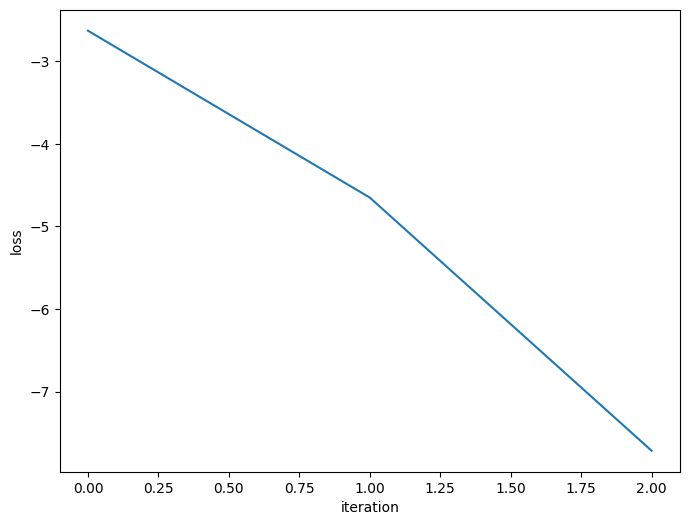

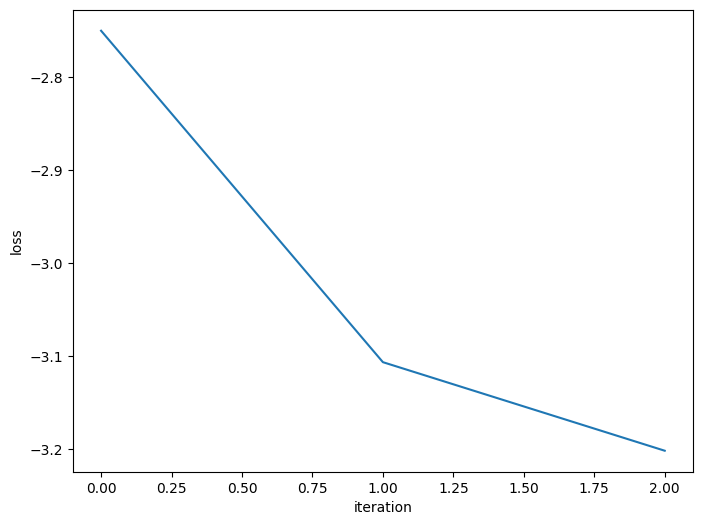

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -631.90537  validloss -552.71324±0.00000  bestvalidloss -552.71324  last_update 0
train: iter 1  trainloss -642.07034  validloss -554.89398±0.00000  bestvalidloss -554.89398  last_update 0
train: iter 2  trainloss -624.04717  validloss -543.39048±0.00000  bestvalidloss -554.89398  last_update 1
train: iter 3  trainloss -640.20575  validloss -552.63529±0.00000  bestvalidloss -554.89398  last_update 2
train: iter 4  trainloss -634.28195  validloss -547.88008±0.00000  bestvalidloss -554.89398  last_update 3
train: iter 5  trainloss -623.30991  validloss -574.22416±0.00000  bestvalidloss -574.22416  last_update 0
train: iter 6  trainloss -600.18620  validloss -520.42448±0.00000  bestvalidloss -574.22416  last_update 1
train: iter 7  trainloss -620.25958  validloss -538.24523±0.00000  bestvalidloss -574.22416  last_update 2
train: iter 8  trainloss -632.58682  validloss -555.02730±0.00000  bestvalidloss -574.22416  last_u

train: iter 75  trainloss -549.44179  validloss -547.22587±0.00000  bestvalidloss -574.22416  last_update 70
train: iter 76  trainloss -505.24660  validloss -337.53658±0.00000  bestvalidloss -574.22416  last_update 71
train: iter 77  trainloss -598.08872  validloss -489.23891±0.00000  bestvalidloss -574.22416  last_update 72
train: iter 78  trainloss -610.54205  validloss -509.11820±0.00000  bestvalidloss -574.22416  last_update 73
train: iter 79  trainloss -622.24059  validloss -530.55758±0.00000  bestvalidloss -574.22416  last_update 74
train: iter 80  trainloss -623.46102  validloss -540.01741±0.00000  bestvalidloss -574.22416  last_update 75
train: iter 81  trainloss -562.12210  validloss -529.12210±0.00000  bestvalidloss -574.22416  last_update 76
train: iter 82  trainloss -605.03709  validloss -463.27159±0.00000  bestvalidloss -574.22416  last_update 77
train: iter 83  trainloss -602.62953  validloss -534.99880±0.00000  bestvalidloss -574.22416  last_update 78
train: iter 84  tra

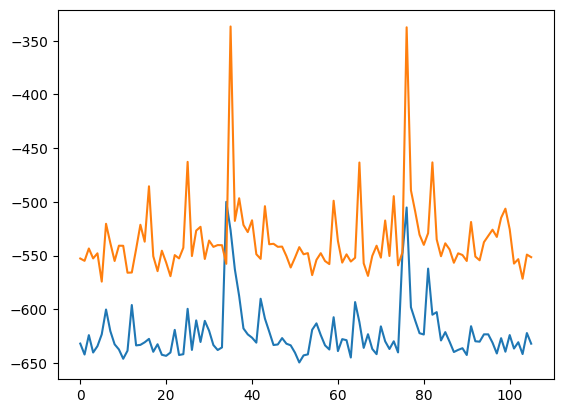

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-31 16:46:32.790423


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6
predict diverge [-5.56211052 -4.12331935 52.18819671 33.5987653 ] [-0.19288306 -2.03078081  1.34880488  9.27609857] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 87

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19
predict diverge [-1.56588943 -9.27996889 21.05542874 41.44975202] [-0.31615781 -1.18779771  1.43299854 11.65149356] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 33

 20

 21

 22

 23

 24
predict diverge [-2.93585201 12.42534744 51.22084941 43.04060642] [ 0.25119447  6.64483057  1.62851512 14.84740095] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 82

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46
predict diverge [-46.50958418 -22.63541807  26.93997111   1.45029995] [-1.1118575  -0.42263763  0.03172655 -1.23947

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.45873  validloss 0.55980±0.00000  bestvalidloss 0.55980  last_update 0
train: iter 1  trainloss 0.42149  validloss 0.43170±0.00000  bestvalidloss 0.43170  last_update 0
train: iter 2  trainloss 0.41167  validloss 0.42641±0.00000  bestvalidloss 0.42641  last_update 0
train: iter 3  trainloss 0.40562  validloss 0.42096±0.00000  bestvalidloss 0.42096  last_update 0
train: iter 4  trainloss 0.39838  validloss 0.43223±0.00000  bestvalidloss 0.42096  last_update 1
train: iter 5  trainloss 0.39237  validloss 0.42000±0.00000  bestvalidloss 0.42000  last_update 0
train: iter 6  trainloss 0.39257  validloss 0.42627±0.00000  bestvalidloss 0.42000  last_update 1
train: iter 7  trainloss 0.38676  validloss 0.41009±0.00000  bestvalidloss 0.41009  last_update 0
train: iter 8  trainloss 0.38454  validloss 0.40764±0.00000  bestvalidloss 0.40764  last_update 0
train: iter 9  trainloss 0.38297  validloss 0.41747±0.00000  bestvalidloss 0.40764  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.31025  validloss 0.37598±0.00000  bestvalidloss 0.36616  last_update 9
train: iter 84  trainloss 0.31226  validloss 0.39646±0.00000  bestvalidloss 0.36616  last_update 10
train: iter 85  trainloss 0.31402  validloss 0.36807±0.00000  bestvalidloss 0.36616  last_update 11
train: iter 86  trainloss 0.31239  validloss 0.36761±0.00000  bestvalidloss 0.36616  last_update 12
train: iter 87  trainloss 0.31186  validloss 0.37170±0.00000  bestvalidloss 0.36616  last_update 13
train: iter 88  trainloss 0.30990  validloss 0.36337±0.00000  bestvalidloss 0.36337  last_update 0
train: iter 89  trainloss 0.30849  validloss 0.36809±0.00000  bestvalidloss 0.36337  last_update 1
train: iter 90  trainloss 0.30998  validloss 0.37069±0.00000  bestvalidloss 0.36337  last_update 2
train: iter 91  trainloss 0.31417  validloss 0.37157±0.00000  bestvalidloss 0.36337  last_update 3
train: iter 92  trainloss 0.31427  validloss 0.37513±0.00000  bestvalidloss 0.36337  last_update 4
train:

train: iter 165  trainloss 0.29497  validloss 0.38108±0.00000  bestvalidloss 0.36283  last_update 57
train: iter 166  trainloss 0.29601  validloss 0.38304±0.00000  bestvalidloss 0.36283  last_update 58
train: iter 167  trainloss 0.29689  validloss 0.38551±0.00000  bestvalidloss 0.36283  last_update 59
train: iter 168  trainloss 0.29202  validloss 0.39392±0.00000  bestvalidloss 0.36283  last_update 60
train: iter 169  trainloss 0.29636  validloss 0.37475±0.00000  bestvalidloss 0.36283  last_update 61
train: iter 170  trainloss 0.29407  validloss 0.38954±0.00000  bestvalidloss 0.36283  last_update 62
train: iter 171  trainloss 0.29570  validloss 0.37255±0.00000  bestvalidloss 0.36283  last_update 63
train: iter 172  trainloss 0.29370  validloss 0.38340±0.00000  bestvalidloss 0.36283  last_update 64
train: iter 173  trainloss 0.29537  validloss 0.39498±0.00000  bestvalidloss 0.36283  last_update 65
train: iter 174  trainloss 0.29746  validloss 0.37467±0.00000  bestvalidloss 0.36283  last_

train_loss:  -6.333080976665019
valid_loss:  -6.33524837589264
weight_alpha 1.0 h_min_tilde -11.760895 ell_tilde -6.333514456510543 kappa_tilde 0.0004292446315661107
train_loss:  -3.8107982857227336
valid_loss:  -3.4476888378143316
weight_alpha 0.1 h_min_tilde -11.760895 ell_tilde -3.738176396141053 kappa_tilde 0.00035305244727351816


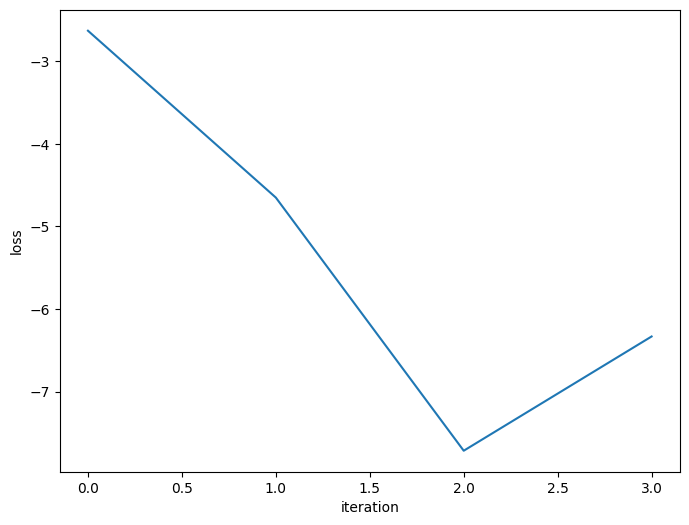

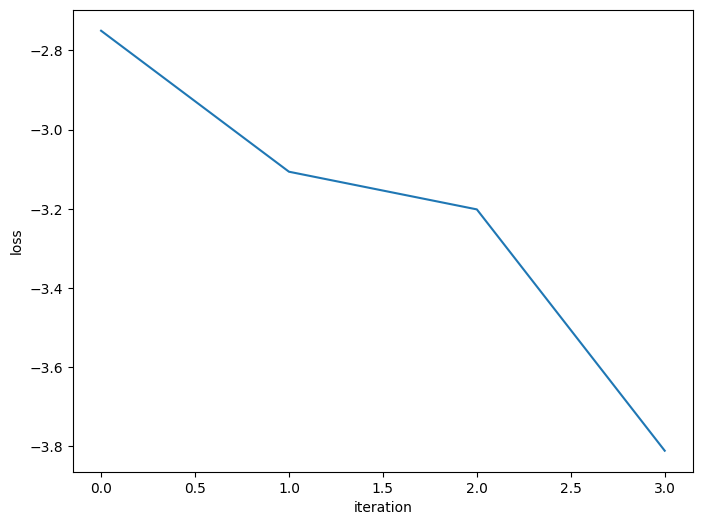

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -742.44172  validloss -690.28391±0.00000  bestvalidloss -690.28391  last_update 0
train: iter 1  trainloss -746.76859  validloss -664.02918±0.00000  bestvalidloss -690.28391  last_update 1
train: iter 2  trainloss -700.46446  validloss -662.79168±0.00000  bestvalidloss -690.28391  last_update 2
train: iter 3  trainloss -748.91365  validloss -686.67678±0.00000  bestvalidloss -690.28391  last_update 3
train: iter 4  trainloss -748.01848  validloss -679.82369±0.00000  bestvalidloss -690.28391  last_update 4
train: iter 5  trainloss -718.54436  validloss -634.76930±0.00000  bestvalidloss -690.28391  last_update 5
train: iter 6  trainloss -757.60418  validloss -698.39865±0.00000  bestvalidloss -698.39865  last_update 0
train: iter 7  trainloss -750.84435  validloss -665.55620±0.00000  bestvalidloss -698.39865  last_update 1
train: iter 8  trainloss -759.94979  validloss -679.59665±0.00000  bestvalidloss -698.39865  last_u

train: iter 76  trainloss -681.34660  validloss -626.41475±0.00000  bestvalidloss -700.56511  last_update 46
train: iter 77  trainloss -726.91105  validloss -625.53913±0.00000  bestvalidloss -700.56511  last_update 47
train: iter 78  trainloss -762.91016  validloss -675.33282±0.00000  bestvalidloss -700.56511  last_update 48
train: iter 79  trainloss -731.71577  validloss -684.24697±0.00000  bestvalidloss -700.56511  last_update 49
train: iter 80  trainloss -754.78600  validloss -674.13336±0.00000  bestvalidloss -700.56511  last_update 50
train: iter 81  trainloss -761.29572  validloss -673.49245±0.00000  bestvalidloss -700.56511  last_update 51
train: iter 82  trainloss -738.92714  validloss -685.90950±0.00000  bestvalidloss -700.56511  last_update 52
train: iter 83  trainloss -737.75515  validloss -647.38170±0.00000  bestvalidloss -700.56511  last_update 53
train: iter 84  trainloss -737.15382  validloss -669.52080±0.00000  bestvalidloss -700.56511  last_update 54
train: iter 85  tra

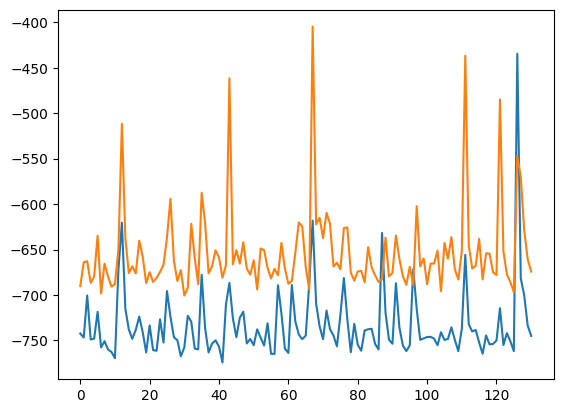

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-31 17:11:35.053543


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15
predict diverge [-140.94212045  -10.29010213  131.42581507   19.67479822] [-64.50692942  -2.70552681   1.43247477  -1.47069927] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 162

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44
predict diverge [-14.13826364 -22.60365765  55.57724763  24.33479343] [-0.97045791 -3.58508372  1.05606958  1.78823728] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 67

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73
predict diverge [-38.85899699 -24.04192453   0.22833449  24.69292958] [ -0.58035882 -11.58999279   0.80839741   2.92852981] [107.82092   22.51174  164.27458   29.974638] [53.91046  11

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.40060  validloss 0.49645±0.00000  bestvalidloss 0.49645  last_update 0
train: iter 1  trainloss 0.36625  validloss 0.39845±0.00000  bestvalidloss 0.39845  last_update 0
train: iter 2  trainloss 0.35793  validloss 0.39193±0.00000  bestvalidloss 0.39193  last_update 0
train: iter 3  trainloss 0.35257  validloss 0.38843±0.00000  bestvalidloss 0.38843  last_update 0
train: iter 4  trainloss 0.35098  validloss 0.39134±0.00000  bestvalidloss 0.38843  last_update 1
train: iter 5  trainloss 0.34778  validloss 0.38378±0.00000  bestvalidloss 0.38378  last_update 0
train: iter 6  trainloss 0.34754  validloss 0.38452±0.00000  bestvalidloss 0.38378  last_update 1
train: iter 7  trainloss 0.34577  validloss 0.38281±0.00000  bestvalidloss 0.38281  last_update 0
train: iter 8  trainloss 0.34088  validloss 0.37880±0.00000  bestvalidloss 0.37880  last_update 0
train: iter 9  trainloss 0.34263  validloss 0.37546±0.00000  bestvalidloss 0.37546  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.31228  validloss 0.35606±0.00000  bestvalidloss 0.35606  last_update 0
train: iter 84  trainloss 0.31472  validloss 0.35878±0.00000  bestvalidloss 0.35606  last_update 1
train: iter 85  trainloss 0.31400  validloss 0.35962±0.00000  bestvalidloss 0.35606  last_update 2
train: iter 86  trainloss 0.31230  validloss 0.36182±0.00000  bestvalidloss 0.35606  last_update 3
train: iter 87  trainloss 0.31322  validloss 0.36878±0.00000  bestvalidloss 0.35606  last_update 4
train: iter 88  trainloss 0.31314  validloss 0.36881±0.00000  bestvalidloss 0.35606  last_update 5
train: iter 89  trainloss 0.31489  validloss 0.36231±0.00000  bestvalidloss 0.35606  last_update 6
train: iter 90  trainloss 0.31187  validloss 0.36066±0.00000  bestvalidloss 0.35606  last_update 7
train: iter 91  trainloss 0.31045  validloss 0.37190±0.00000  bestvalidloss 0.35606  last_update 8
train: iter 92  trainloss 0.31122  validloss 0.36162±0.00000  bestvalidloss 0.35606  last_update 9
train: ite

train: iter 165  trainloss 0.29981  validloss 0.36481±0.00000  bestvalidloss 0.35433  last_update 15
train: iter 166  trainloss 0.30148  validloss 0.37257±0.00000  bestvalidloss 0.35433  last_update 16
train: iter 167  trainloss 0.29972  validloss 0.36389±0.00000  bestvalidloss 0.35433  last_update 17
train: iter 168  trainloss 0.30106  validloss 0.36467±0.00000  bestvalidloss 0.35433  last_update 18
train: iter 169  trainloss 0.30052  validloss 0.36040±0.00000  bestvalidloss 0.35433  last_update 19
train: iter 170  trainloss 0.29917  validloss 0.35744±0.00000  bestvalidloss 0.35433  last_update 20
train: iter 171  trainloss 0.29890  validloss 0.36597±0.00000  bestvalidloss 0.35433  last_update 21
train: iter 172  trainloss 0.29545  validloss 0.36276±0.00000  bestvalidloss 0.35433  last_update 22
train: iter 173  trainloss 0.30137  validloss 0.36315±0.00000  bestvalidloss 0.35433  last_update 23
train: iter 174  trainloss 0.29892  validloss 0.36558±0.00000  bestvalidloss 0.35433  last_

train: iter 247  trainloss 0.28792  validloss 0.36249±0.00000  bestvalidloss 0.35342  last_update 57
train: iter 248  trainloss 0.29088  validloss 0.36879±0.00000  bestvalidloss 0.35342  last_update 58
train: iter 249  trainloss 0.28904  validloss 0.36796±0.00000  bestvalidloss 0.35342  last_update 59
train: iter 250  trainloss 0.28826  validloss 0.39174±0.00000  bestvalidloss 0.35342  last_update 60
train: iter 251  trainloss 0.28827  validloss 0.36645±0.00000  bestvalidloss 0.35342  last_update 61
train: iter 252  trainloss 0.28991  validloss 0.38519±0.00000  bestvalidloss 0.35342  last_update 62
train: iter 253  trainloss 0.28998  validloss 0.38619±0.00000  bestvalidloss 0.35342  last_update 63
train: iter 254  trainloss 0.29116  validloss 0.37303±0.00000  bestvalidloss 0.35342  last_update 64
train: iter 255  trainloss 0.28719  validloss 0.37767±0.00000  bestvalidloss 0.35342  last_update 65
train: iter 256  trainloss 0.28910  validloss 0.38252±0.00000  bestvalidloss 0.35342  last_

train_loss:  -6.982968833029268
valid_loss:  -7.497779521560669
weight_alpha 1.0 h_min_tilde -11.83957 ell_tilde -7.085930970735549 kappa_tilde 0.00045865580845612727
train_loss:  -3.4878063145399087
valid_loss:  -3.133916505432129
weight_alpha 0.1 h_min_tilde -11.83957 ell_tilde -3.417028352718353 kappa_tilde 0.00034457075561217064


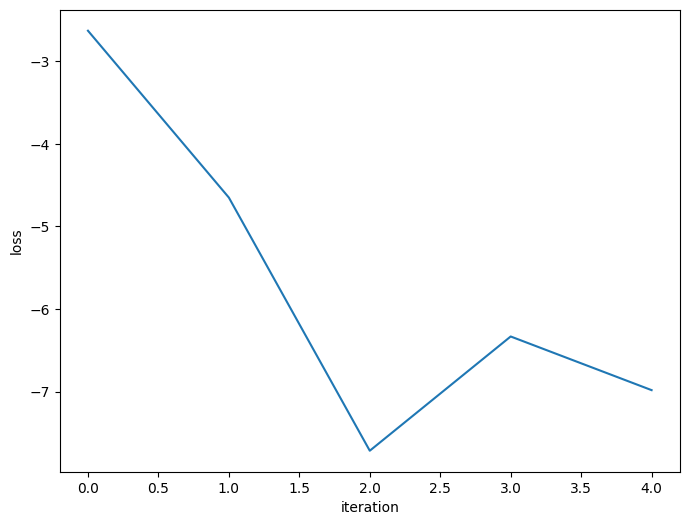

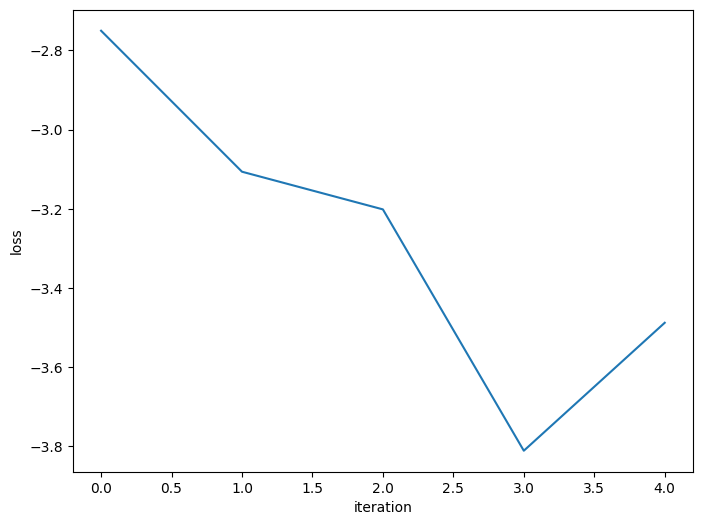

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -678.42975  validloss -628.60492±0.00000  bestvalidloss -628.60492  last_update 0
train: iter 1  trainloss -712.87813  validloss -601.39179±0.00000  bestvalidloss -628.60492  last_update 1
train: iter 2  trainloss -711.91058  validloss -627.92832±0.00000  bestvalidloss -628.60492  last_update 2
train: iter 3  trainloss -704.40616  validloss -623.21047±0.00000  bestvalidloss -628.60492  last_update 3
train: iter 4  trainloss -706.64461  validloss -635.79002±0.00000  bestvalidloss -635.79002  last_update 0
train: iter 5  trainloss -713.79494  validloss -625.69512±0.00000  bestvalidloss -635.79002  last_update 1
train: iter 6  trainloss -706.31251  validloss -615.76592±0.00000  bestvalidloss -635.79002  last_update 2
train: iter 7  trainloss -721.07626  validloss -625.04799±0.00000  bestvalidloss -635.79002  last_update 3
train: iter 8  trainloss -672.37890  validloss -638.75099±0.00000  bestvalidloss -638.75099  last_u

train: iter 76  trainloss -639.28201  validloss -598.56927±0.00000  bestvalidloss -643.10813  last_update 45
train: iter 77  trainloss -587.77688  validloss -327.14410±0.00000  bestvalidloss -643.10813  last_update 46
train: iter 78  trainloss -668.33119  validloss -590.10644±0.00000  bestvalidloss -643.10813  last_update 47
train: iter 79  trainloss -700.87746  validloss -604.50341±0.00000  bestvalidloss -643.10813  last_update 48
train: iter 80  trainloss -626.39959  validloss -607.94892±0.00000  bestvalidloss -643.10813  last_update 49
train: iter 81  trainloss -694.67342  validloss -616.77438±0.00000  bestvalidloss -643.10813  last_update 50
train: iter 82  trainloss -707.43524  validloss -621.65615±0.00000  bestvalidloss -643.10813  last_update 51
train: iter 83  trainloss -693.86197  validloss -626.18066±0.00000  bestvalidloss -643.10813  last_update 52
train: iter 84  trainloss -706.51628  validloss -612.44149±0.00000  bestvalidloss -643.10813  last_update 53
train: iter 85  tra

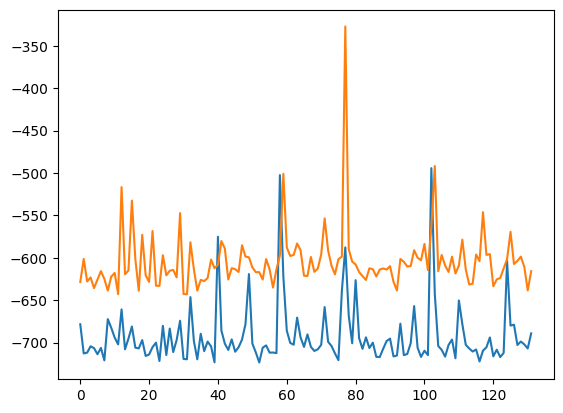

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-31 17:36:51.446666


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.40141  validloss 0.42617±0.00000  bestvalidloss 0.42617  last_update 0
train: iter 1  trainloss 0.37557  validloss 0.39573±0.00000  bestvalidloss 0.39573  last_update 0
train: iter 2  trainloss 0.36974  validloss 0.39009±0.00000  bestvalidloss 0.39009  last_update 0
train: iter 3  trainloss 0.36750  validloss 0.39069±0.00000  bestvalidloss 0.39009  last_update 1
train: iter 4  trainloss 0.35891  validloss 0.38362±0.00000  bestvalidloss 0.38362  last_update 0
train: iter 5  trainloss 0.35785  validloss 0.38382±0.00000  bestvalidloss 0.38362  last_update 1
train: iter 6  trainloss 0.35252  validloss 0.38419±0.00000  bestvalidloss 0.38362  last_update 2
train: iter 7  trainloss 0.35100  validloss 0.39112±0.00000  bestvalidloss 0.38362  last_update 3
train: iter 8  trainloss 0.34804  validloss 0.38066±0.00000  bestvalidloss 0.38066  last_update 0
train: iter 9  trainloss 0.34627  validloss 0.38333±0.00000  bestvalidloss 0.38066  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.31445  validloss 0.36284±0.00000  bestvalidloss 0.36216  last_update 13
train: iter 84  trainloss 0.31238  validloss 0.36756±0.00000  bestvalidloss 0.36216  last_update 14
train: iter 85  trainloss 0.31391  validloss 0.36745±0.00000  bestvalidloss 0.36216  last_update 15
train: iter 86  trainloss 0.31143  validloss 0.36801±0.00000  bestvalidloss 0.36216  last_update 16
train: iter 87  trainloss 0.31206  validloss 0.36648±0.00000  bestvalidloss 0.36216  last_update 17
train: iter 88  trainloss 0.30928  validloss 0.36527±0.00000  bestvalidloss 0.36216  last_update 18
train: iter 89  trainloss 0.30913  validloss 0.36224±0.00000  bestvalidloss 0.36216  last_update 19
train: iter 90  trainloss 0.31081  validloss 0.36524±0.00000  bestvalidloss 0.36216  last_update 20
train: iter 91  trainloss 0.31176  validloss 0.36596±0.00000  bestvalidloss 0.36216  last_update 21
train: iter 92  trainloss 0.30932  validloss 0.36468±0.00000  bestvalidloss 0.36216  last_update 22


train: iter 165  trainloss 0.29974  validloss 0.36818±0.00000  bestvalidloss 0.36138  last_update 63
train: iter 166  trainloss 0.29703  validloss 0.37370±0.00000  bestvalidloss 0.36138  last_update 64
train: iter 167  trainloss 0.29901  validloss 0.36743±0.00000  bestvalidloss 0.36138  last_update 65
train: iter 168  trainloss 0.29711  validloss 0.37280±0.00000  bestvalidloss 0.36138  last_update 66
train: iter 169  trainloss 0.29799  validloss 0.36901±0.00000  bestvalidloss 0.36138  last_update 67
train: iter 170  trainloss 0.29618  validloss 0.36894±0.00000  bestvalidloss 0.36138  last_update 68
train: iter 171  trainloss 0.29932  validloss 0.37075±0.00000  bestvalidloss 0.36138  last_update 69
train: iter 172  trainloss 0.29708  validloss 0.38102±0.00000  bestvalidloss 0.36138  last_update 70
train: iter 173  trainloss 0.29648  validloss 0.36844±0.00000  bestvalidloss 0.36138  last_update 71
train: iter 174  trainloss 0.29660  validloss 0.36655±0.00000  bestvalidloss 0.36138  last_

([0.4014096427243203,
  0.37556731472723187,
  0.3697384152561426,
  0.36750207711011174,
  0.3589139699935913,
  0.3578475909307599,
  0.3525241718161851,
  0.3510045360773802,
  0.3480390962678939,
  0.3462717498652637,
  0.34414006588049234,
  0.3461413744837046,
  0.3423947115428746,
  0.34058134383521976,
  0.3424491417128593,
  0.33619246082380416,
  0.3361068580299616,
  0.33672874784097073,
  0.3368337127845734,
  0.3362437213771045,
  0.33563283998519183,
  0.3329646223224699,
  0.3352462652139366,
  0.33159565916284917,
  0.3334523545578122,
  0.3301387699786574,
  0.32906784433871505,
  0.32874448839575054,
  0.32688969881273805,
  0.3293634776957333,
  0.32838770584203303,
  0.32689325511455536,
  0.32542721508070827,
  0.3261275509838015,
  0.3257105561904609,
  0.3278046210296452,
  0.32550753336399796,
  0.32148572374135254,
  0.3247489749453962,
  0.32430284945294263,
  0.3270387827418745,
  0.3228047608397901,
  0.32321707550436257,
  0.3229577472433448,
  0.3239001943

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -7.218991374966504
valid_loss:  -7.737925801849364
weight_alpha 1.0 h_min_tilde -11.812978 ell_tilde -7.322778260343076 kappa_tilde 0.00047191869253472324
train_loss:  -3.7775201789379116
valid_loss:  -3.24870934047699
weight_alpha 0.1 h_min_tilde -11.812978 ell_tilde -3.671758011245727 kappa_tilde 0.00035047356035591273


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 125.64807  validloss 136.67500±0.00000  bestvalidloss 136.67500  last_update 0
train: iter 1  trainloss 103.26286  validloss 113.78926±0.00000  bestvalidloss 113.78926  last_update 0
train: iter 2  trainloss 85.91506  validloss 93.23084±0.00000  bestvalidloss 93.23084  last_update 0
train: iter 3  trainloss 71.59318  validloss 77.68286±0.00000  bestvalidloss 77.68286  last_update 0
train: iter 4  trainloss 60.24657  validloss 64.34447±0.00000  bestvalidloss 64.34447  last_update 0
train: iter 5  trainloss 50.50513  validloss 55.09299±0.00000  bestvalidloss 55.09299  last_update 0
train: iter 6  trainloss 43.30130  validloss 46.07929±0.00000  bestvalidloss 46.07929  last_update 0
train: iter 7  trainloss 36.27649  validloss 39.01819±0.00000  bestvalidloss 39.01819  last_update 0
train: iter 8  trainloss 30.89371  validloss 32.41696±0.00000  bestvalidloss 32.41696  last_update 0
train: iter 9  trainloss 26.29449  validloss 28.16870±0.00000  bestvalidloss 28.16870

train: iter 81  trainloss -0.07696  validloss -0.21216±0.00000  bestvalidloss -0.28454  last_update 30
train: iter 82  trainloss -0.11140  validloss -0.16587±0.00000  bestvalidloss -0.28454  last_update 31
train: iter 83  trainloss -0.08065  validloss -0.22436±0.00000  bestvalidloss -0.28454  last_update 32
train: iter 84  trainloss -0.07430  validloss -0.13506±0.00000  bestvalidloss -0.28454  last_update 33
train: iter 85  trainloss -0.06052  validloss -0.21262±0.00000  bestvalidloss -0.28454  last_update 34
train: iter 86  trainloss -0.07528  validloss -0.14211±0.00000  bestvalidloss -0.28454  last_update 35
train: iter 87  trainloss -0.09487  validloss -0.19871±0.00000  bestvalidloss -0.28454  last_update 36
train: iter 88  trainloss -0.06313  validloss -0.18056±0.00000  bestvalidloss -0.28454  last_update 37
train: iter 89  trainloss -0.11079  validloss -0.23655±0.00000  bestvalidloss -0.28454  last_update 38
train: iter 90  trainloss -0.08360  validloss -0.15315±0.00000  bestvalid

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-0.8733, -2.1913, -2.0300, -4.2149], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 8.95188  validloss 16.94669±0.00000  bestvalidloss 16.94669  last_update 0
train: iter 1  trainloss 7.32380  validloss 16.08312±0.00000  bestvalidloss 16.08312  last_update 0
train: iter 2  trainloss 7.10631  validloss 15.14798±0.00000  bestvalidloss 15.14798  last_update 0
train: iter 3  trainloss 6.96376  validloss 15.64942±0.00000  bestvalidloss 15.14798  last_update 1
train: iter 4  trainloss 6.75690  validloss 15.11173±0.00000  bestvalidloss 15.11173  last_update 0
train: iter 5  trainloss 6.74547  validloss 15.07620±0.00000  bestvalidloss 15.07620  last_update 0
train: iter 6  trainloss 6.80063  validloss 15.57774±0.00000  bestvalidloss 15.07620  last_update 1
train: iter 7  trainloss 6.70104  validloss 15.48236±0.00000  bestvalidloss 15.07620  last_update 2
train: iter 8  trainloss 6.71913  validloss 15.40066±0.00000  bestvalidloss 15.07620  last_update 3
train: iter 9  trainloss 6.85703  validloss 15.05216±0.00000  bestvalidloss 15.05216  last_update 0


train: iter 82  trainloss 6.40996  validloss 15.86306±0.00000  bestvalidloss 14.41050  last_update 27
train: iter 83  trainloss 6.43681  validloss 15.07565±0.00000  bestvalidloss 14.41050  last_update 28
train: iter 84  trainloss 6.48227  validloss 15.73036±0.00000  bestvalidloss 14.41050  last_update 29
train: iter 85  trainloss 6.40985  validloss 15.10607±0.00000  bestvalidloss 14.41050  last_update 30
train: iter 86  trainloss 6.48017  validloss 16.23136±0.00000  bestvalidloss 14.41050  last_update 31
train: iter 87  trainloss 6.42645  validloss 15.59540±0.00000  bestvalidloss 14.41050  last_update 32
train: iter 88  trainloss 6.40830  validloss 15.79585±0.00000  bestvalidloss 14.41050  last_update 33
train: iter 89  trainloss 6.46885  validloss 15.82777±0.00000  bestvalidloss 14.41050  last_update 34
train: iter 90  trainloss 6.41370  validloss 15.97890±0.00000  bestvalidloss 14.41050  last_update 35
train: iter 91  trainloss 6.36893  validloss 15.70260±0.00000  bestvalidloss 14.41

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-9.3095)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(12.8906)


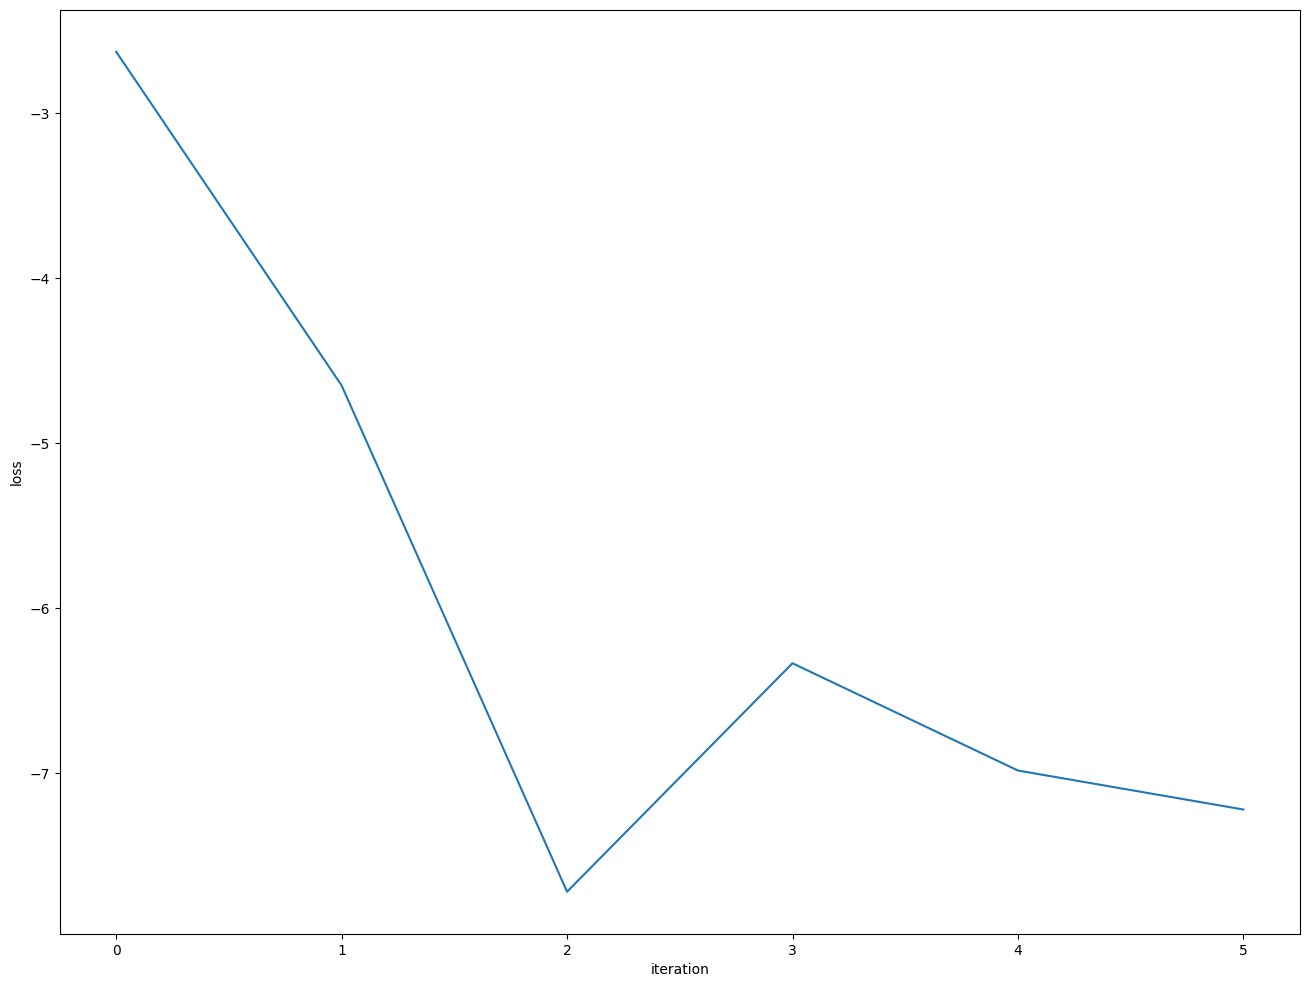

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

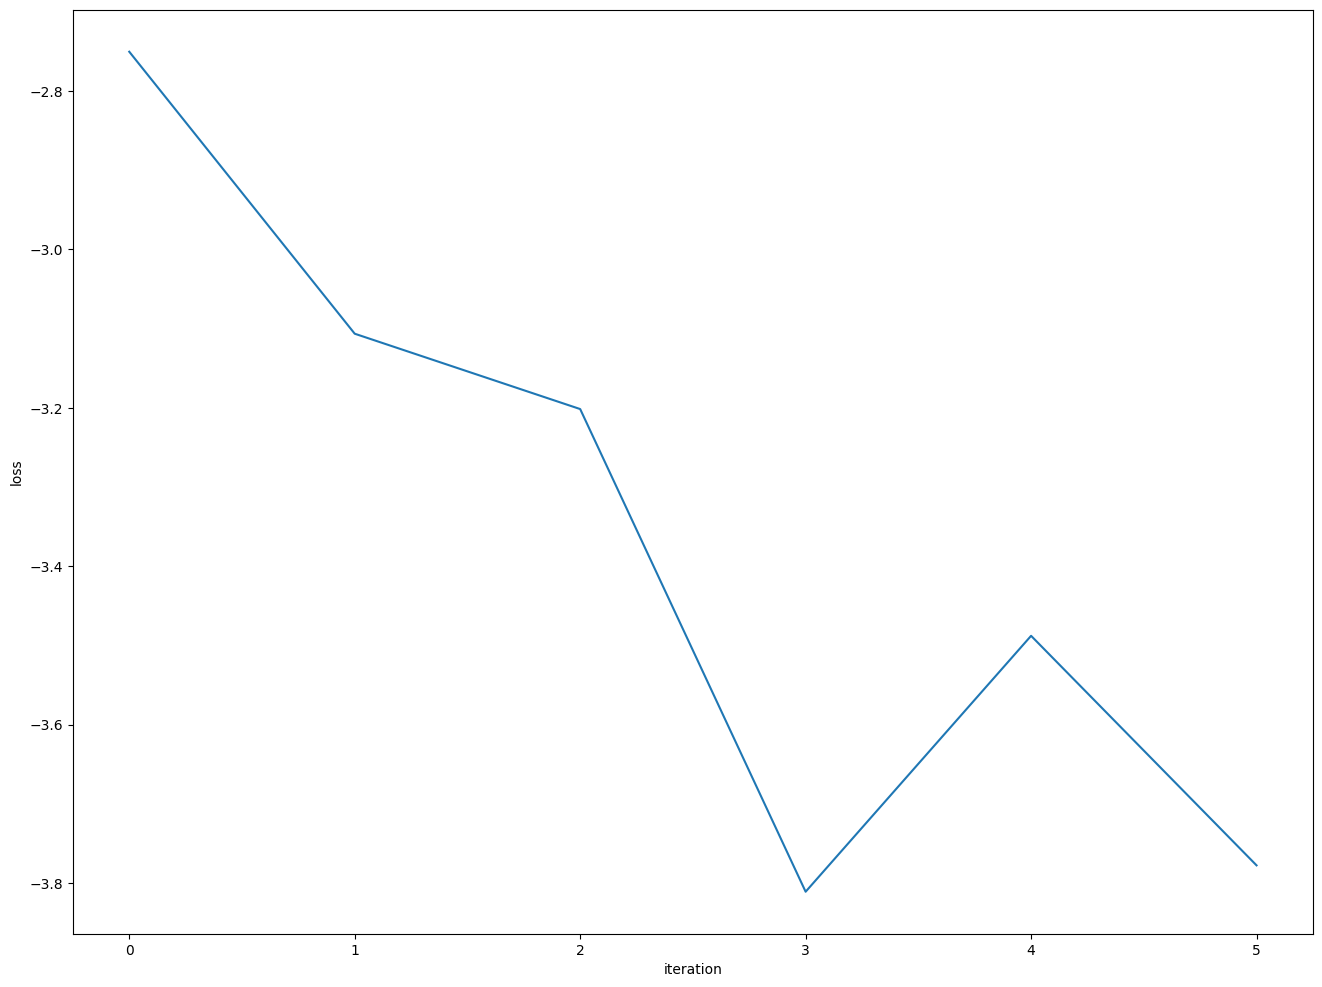

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")